<a href="https://colab.research.google.com/github/luc-perso/covid-19-xRay/blob/main/code_by_stefan/preprocessing_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Start with drive, unzip and modules

##drive unzip





In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#new_data
!unzip -q '/content/drive/MyDrive/datas/datanew.zip' -d '/content/'

In [ ]:
#new_data
!unzip -q '/content/drive/MyDrive/datas/datanewjustimages.zip' -d '/content/'

In [ ]:
#equalized data
!unzip -q '/content/drive/MyDrive/datas/data_equalize.zip' -d '/content/'

In [ ]:
# cropped
!unzip -q '/content/drive/MyDrive/datas/data_cropped_lungs' -d '/content/'

In [ ]:
pip install --upgrade tensorflow

##Moduls

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import json
import random
import itertools 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter






In [ ]:
def path_creator(db_path1, lu_inf,tr_te_val, desease, img):
  path = data_paths['path'].loc[idx[[lu_inf], tr_te_val, desease, img]][0]
  full_file_path = os.path.join(db_path1, path)
  return full_file_path

def img_path_n_list(path,class_num):
  img_path_list =[]
  img_list=[]  
  
  for img in os.listdir(path):
    try:
      file_path = os.path.join(path, img)
      img_path_list.append(file_path)
  
      # I import the images in gray scale
      img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
      #img_array = img_array.astype(float) / 255.0
    except:
      continue
    img_list.append([img_array,class_num])
  return img_path_list, img_list

# new data creation

##directorys

In [ ]:
#Datasets

db_path1 = '/content/data'

if not os.path.exists(output_path):
  os.makedirs(output_path, exist_ok=True)

#############data names 

lung_name = 'lung'
infection_name = 'infection'

train_name = 'train'
test_name = 'test'
valid_name = 'valid'

no_covid_name = 'no_covid'
covid_name = 'covid19'
normal_name = 'normal'

images_name = 'images'
masks_name = 'masks'

lung_mask_name = lung_name + '_' + masks_name
infection_mask_name = infection_name + '_' + masks_name


#############data directory names 

lung_dirname = 'Lung Segmentation Data'
infection_dirname = 'Infection Segmentation Data'

train_dirname = 'Train'
test_dirname = 'Test'
valid_dirname = 'Val'

no_covid_dirname = 'Non-COVID'
covid_dirname = 'COVID-19'
normal_dirname = 'Normal'

images_dirname = 'images'
lung_masks_dirname = 'lung masks'
infection_masks_dirname = 'infection masks'

In [ ]:
############ pathes
db_names = pd.DataFrame(data={
  'db_name': [lung_name, infection_name],
  'db_dirname': [lung_dirname, infection_dirname]
  })
ds_names = pd.DataFrame(data={
  'ds_name': [train_name, test_name, valid_name],
  'ds_dirname': [train_dirname, test_dirname, valid_dirname]
  })
desease_names = pd.DataFrame(data={
  'desease_name': [no_covid_name, covid_name, normal_name],
  'desease_dirname': [no_covid_dirname, covid_dirname, normal_dirname]
  })
data_type_names = pd.DataFrame(data={
  'data_type_name': [images_name, lung_mask_name, infection_mask_name],
  'data_type_dirname': [images_dirname, lung_masks_dirname, infection_masks_dirname]
  })
print(db_names)
print(ds_names)
print(desease_names)
print(data_type_names)

db_names['keys'] = 1
ds_names['keys'] = 1
desease_names['keys'] = 1
data_type_names['keys'] = 1

#db_names
data_paths = pd.merge(db_names, ds_names, on='keys')
data_paths = pd.merge(data_paths, desease_names, on='keys')
data_paths = pd.merge(data_paths, data_type_names, on='keys')
data_paths = data_paths.drop(columns=['keys'])
#data_paths
data_paths = data_paths.set_index(['db_name', 'ds_name', 'desease_name', 'data_type_name'])
data_paths['path'] = data_paths.apply(lambda x: os.path.join(*(x.to_list())), axis=1)
data_paths = data_paths.iloc[:, -1:]

#data_paths
idx = pd.IndexSlice
index = data_paths.loc[idx[[lung_name],:,:,infection_mask_name]].index
print(index)
data_paths = data_paths.drop(index)

     db_name                   db_dirname
0       lung       Lung Segmentation Data
1  infection  Infection Segmentation Data
  ds_name ds_dirname
0   train      Train
1    test       Test
2   valid        Val
  desease_name desease_dirname
0     no_covid       Non-COVID
1      covid19        COVID-19
2       normal          Normal
    data_type_name data_type_dirname
0           images            images
1       lung_masks        lung masks
2  infection_masks   infection masks
MultiIndex([('lung', 'train', 'no_covid', 'infection_masks'),
            ('lung', 'train',  'covid19', 'infection_masks'),
            ('lung', 'train',   'normal', 'infection_masks'),
            ('lung',  'test', 'no_covid', 'infection_masks'),
            ('lung',  'test',  'covid19', 'infection_masks'),
            ('lung',  'test',   'normal', 'infection_masks'),
            ('lung', 'valid', 'no_covid', 'infection_masks'),
            ('lung', 'valid',  'covid19', 'infection_masks'),
            ('lung', '

In [ ]:
#####test example
path = data_paths['path'].loc[idx[[lung_name], valid_name, covid_name, images_name]][0]
print(path)
full_file_path = os.path.join(db_path1, path)
file_names = os.listdir(full_file_path)
file_names
print(file_names[0])
'''
n = np.random.randint(0, len(file_names))
print(n)
file_name = file_names[n]
#file_name = 'covid_1256.png'
#file_name = 'sub-S09683_ses-E25533_run-1_bp-chest_vp-ap_cr.png'
'''

Lung Segmentation Data/Val/COVID-19/images
sub-S09725_ses-E26526_run-1_bp-chest_vp-pa_cr.png


"\nn = np.random.randint(0, len(file_names))\nprint(n)\nfile_name = file_names[n]\n#file_name = 'covid_1256.png'\n#file_name = 'sub-S09683_ses-E25533_run-1_bp-chest_vp-ap_cr.png'\n"

##function

In [ ]:
def path_creator(db_path, lu_inf,tr_te_val, desease, img):
  path = data_paths['path'].loc[idx[[lu_inf], tr_te_val, desease, img]][0]
  full_file_path = os.path.join(db_path, path)
  return full_file_path

In [ ]:
####equalize####
def equal(x):
    equal = cv2.equalizeHist(x)
    return equal

In [ ]:
##### centering the image #######

def center(image):
  points = cv2.findNonZero(image) # find nonzero pixel
  #listing x and y values
  xlist=[]
  for i in range(0, points.shape[0]):
    x=points[i][0][0]
    xlist.append(x)

  ylist=[]
  for i in range(0, points.shape[0]):
    y=points[i][0][1]
    ylist.append(y)
 #define the edges of region of interest
  yb=min(ylist)
  ye=max(ylist)
  xb=min(xlist)
  xe=max(xlist)
 #cropping
  region_of_interest = image[yb:ye, xb:xe]
  # resizing to 256*256
  region_of_interest = cv2.resize(region_of_interest,dsize=(256, 256), interpolation = cv2.INTER_CUBIC)
  return region_of_interest

In [ ]:
def new(path, pathm):
  lst1=os.listdir(pathm)
  lst1.sort()
  lst2=(os.listdir(path))
  lst2.sort()
  
  
  for img,msk in zip(lst2,lst1):
  
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    msk_array = cv2.imread(os.path.join(pathm, msk), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    msk_array = cv2.resize(msk_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    img_array = equal(img_array)
    image = cv2.bitwise_and(msk_array, img_array,cv2.IMREAD_GRAYSCALE)
    image = center(image)  

    label = pathm[14:]
    cv2.imwrite('/content/drive/MyDrive/datas/data_cropped_lungs/'+label +'/' + img, image)
   
    

##creation of cropped equalized lung masks

### train

In [ ]:
p1=path_creator(db_path1, lung_name,train_name, covid_name, images_name)
p2=path_creator(db_path1, lung_name,train_name, no_covid_name, images_name)
p3=path_creator(db_path1, lung_name,train_name, normal_name, images_name)
p4=path_creator(db_path1, infection_name,train_name, covid_name, images_name)
p5=path_creator(db_path1, infection_name,train_name, no_covid_name, images_name)
p6=path_creator(db_path1, infection_name,train_name, normal_name, images_name)

pm1=path_creator(db_path1, lung_name,train_name, covid_name, lung_mask_name)
pm2=path_creator(db_path1, lung_name,train_name, no_covid_name, lung_mask_name)
pm3=path_creator(db_path1, lung_name,train_name, normal_name, lung_mask_name)
pm4=path_creator(db_path1, infection_name,train_name, covid_name, lung_mask_name)
pm5=path_creator(db_path1, infection_name,train_name, no_covid_name, lung_mask_name)
pm6=path_creator(db_path1, infection_name,train_name, normal_name, lung_mask_name)

In [ ]:
path_list=[p1,p2,p3,p4,p5,p6]
pathm_list=[pm1,pm2,pm3,pm4,pm5,pm6]
for i,j in zip(path_list,pathm_list,):
  lst1=os.listdir(i)
  lst1.sort()
  lst2=os.listdir(j)
  lst2.sort()
  count=0
  for x,y in zip(lst1,lst2):
    if x==y:
      pass
    else:
      count+=1
      print (count,i,x,y,"false")  

In [ ]:
new(p1,pm1)
new(p2,pm2)
new(p3,pm3)
new(p4,pm4)
new(p5,pm5)
new(p6,pm6)

### test

In [ ]:
p1=path_creator(db_path1, lung_name,test_name, covid_name, images_name)
p2=path_creator(db_path1, lung_name,test_name, no_covid_name, images_name)
p3=path_creator(db_path1, lung_name,test_name, normal_name, images_name)
p4=path_creator(db_path1, infection_name,test_name, covid_name, images_name)
p5=path_creator(db_path1, infection_name,test_name, no_covid_name, images_name)
p6=path_creator(db_path1, infection_name,test_name, normal_name, images_name)

pm1=path_creator(db_path1, lung_name,test_name, covid_name, lung_mask_name)
pm2=path_creator(db_path1, lung_name,test_name, no_covid_name, lung_mask_name)
pm3=path_creator(db_path1, lung_name,test_name, normal_name, lung_mask_name)
pm4=path_creator(db_path1, infection_name,test_name, covid_name, lung_mask_name)
pm5=path_creator(db_path1, infection_name,test_name, no_covid_name, lung_mask_name)
pm6=path_creator(db_path1, infection_name,test_name, normal_name, lung_mask_name)

In [ ]:
path_list=[p1,p2,p3,p4,p5,p6]
pathm_list=[pm1,pm2,pm3,pm4,pm5,pm6]
for i,j in zip(path_list,pathm_list,):
  lst1=os.listdir(i)
  lst1.sort()
  lst2=os.listdir(j)
  lst2.sort()
  count=0
  for x,y in zip(lst1,lst2):
    if x==y:
      pass
    else:
      count+=1
      print (count,i,x,y,"false")  

In [ ]:
new(p1,pm1)
new(p2,pm2)
new(p3,pm3)
new(p4,pm4)
new(p5,pm5)
new(p6,pm6)

### val

In [ ]:
p1=path_creator(db_path1, lung_name,valid_name, covid_name, images_name)
p2=path_creator(db_path1, lung_name,valid_name, no_covid_name, images_name)
p3=path_creator(db_path1, lung_name,valid_name, normal_name, images_name)
p4=path_creator(db_path1, infection_name,valid_name, covid_name, images_name)
p5=path_creator(db_path1, infection_name,valid_name, no_covid_name, images_name)
p6=path_creator(db_path1, infection_name,valid_name, normal_name, images_name)

pm1=path_creator(db_path1, lung_name,valid_name, covid_name, lung_mask_name)
pm2=path_creator(db_path1, lung_name,valid_name, no_covid_name, lung_mask_name)
pm3=path_creator(db_path1, lung_name,valid_name, normal_name, lung_mask_name)
pm4=path_creator(db_path1, infection_name,valid_name, covid_name, lung_mask_name)
pm5=path_creator(db_path1, infection_name,valid_name, no_covid_name, lung_mask_name)
pm6=path_creator(db_path1, infection_name,valid_name, normal_name, lung_mask_name)

In [ ]:
path_list=[p1,p2,p3,p4,p5,p6]
pathm_list=[pm1,pm2,pm3,pm4,pm5,pm6]
for i,j in zip(path_list,pathm_list,):
  lst1=os.listdir(i)
  lst1.sort()
  lst2=os.listdir(j)
  lst2.sort()
  count=0
  for x,y in zip(lst1,lst2):
    if x==y:
      pass
    else:
      count+=1
      print (count,i,x,y,"false")  

In [ ]:
new(p1,pm1)
new(p2,pm2)
new(p3,pm3)
new(p4,pm4)
new(p5,pm5)
new(p6,pm6)

# Global average for each class

##Dataframe Creation for mean Lung segmentation images

###functions

In [ ]:
###### data import#########
# method for data import to a list and df
#import in grayscale and dsize 256*256 
def data_n_frame(catdir,sub, column_name):
    data_name =[]
    for x in sub:
        path = os.path.join(catdir, x)

        for img in os.listdir(path):
            # I import the images in gray scale
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
            data_name.append([img_array])
    dataframe = pd.DataFrame(data_name)
    dataframe = dataframe.rename(columns={0: column_name})

    return data_name, dataframe

In [ ]:
###### Classes Assignment #####
##for example, df_class = "covid"
def df_class( df_name,df_class):
    df_name["class"]= f"{df_class}"
    return df_name

###unpreprocessed

In [ ]:
# joining all images with class to df
# creation of dfs
#Covid-19
_, df_xray_cov_test =data_n_frame('/content/data/Lung Segmentation Data/Test/COVID-19',['images'],  "xray")
_, df_xray_cov_train =data_n_frame('/content/data/Lung Segmentation Data/Train/COVID-19',['images'],  "xray")
_, df_xray_cov_val =data_n_frame('/content/data/Lung Segmentation Data/Val/COVID-19',['images'],  "xray")

#concat all dfs of class
df_cov=pd.concat([df_xray_cov_test,df_xray_cov_train,df_xray_cov_val],ignore_index=True)

# assigning class
df_cov =df_class(df_cov, "covid")

In [ ]:
# joining all images with class to df
# creation of dfs
# Non-Covid
_, df_xray_non_test =data_n_frame('/content/data/Lung Segmentation Data/Test/Non-COVID',['images'],  "xray")
_, df_xray_non_train =data_n_frame('/content/data/Lung Segmentation Data/Train/Non-COVID',['images'],  "xray")
_, df_xray_non_val =data_n_frame('/content/data/Lung Segmentation Data/Val/Non-COVID',['images'],  "xray")

#concat all dfs of class
df_non=pd.concat([df_xray_non_test,df_xray_non_train,df_xray_non_val],ignore_index=True)

# assigning class
df_non =df_class(df_non, "non-covid")

In [ ]:
# joining all images with class to df
# creation of dfs
# Normal
_, df_xray_norm_test =data_n_frame('/content/data/Lung Segmentation Data/Test/Normal',['images'],  "xray")
_, df_xray_norm_train =data_n_frame('/content/data/Lung Segmentation Data/Train/Normal',['images'],  "xray")
_, df_xray_norm_val =data_n_frame('/content/data/Lung Segmentation Data/Val/Normal',['images'],  "xray")

#concat all dfs of class
df_norm=pd.concat([df_xray_norm_test,df_xray_norm_train,df_xray_norm_val],ignore_index=True)

# assigning class
df_norm =df_class(df_norm, "normal")

### equalized images

In [ ]:
# joining all images with class to df
# creation of dfs
#Covid-19
_, df_xray_cov_test =data_n_frame('/content/data_equalize/Lung Segmentation Data/Test/COVID-19',['images'],  "xray")
_, df_xray_cov_train =data_n_frame('/content/data_equalize/Lung Segmentation Data/Train/COVID-19',['images'],  "xray")
_, df_xray_cov_val =data_n_frame('/content/data_equalize/Lung Segmentation Data/Val/COVID-19',['images'],  "xray")

#concat all dfs of class
df_cov=pd.concat([df_xray_cov_test,df_xray_cov_train,df_xray_cov_val],ignore_index=True)

# assigning class
df_cov_e =df_class(df_cov, "covid")

In [ ]:
# joining all images with class to df
# creation of dfs
# Non-Covid
_, df_xray_non_test =data_n_frame('/content/data_equalize/Lung Segmentation Data/Test/Non-COVID',['images'],  "xray")
_, df_xray_non_train =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Train/Non-COVID',['images'],  "xray")
_, df_xray_non_val =data_n_frame('/content/data_equalize/Lung Segmentation Data/Val/Non-COVID',['images'],  "xray")

#concat all dfs of class
df_non=pd.concat([df_xray_non_test,df_xray_non_train,df_xray_non_val],ignore_index=True)

# assigning class
df_non_e =df_class(df_non, "non-covid")

In [ ]:
# joining all images with class to df
# creation of dfs
# Normal
_, df_xray_norm_test =data_n_frame('/content/data_equalize/Lung Segmentation Data/Test/Normal',['images'],  "xray")
_, df_xray_norm_train =data_n_frame('/content/data_equalize/Lung Segmentation Data/Train/Normal',['images'],  "xray")
_, df_xray_norm_val =data_n_frame('/content/data_equalize/Lung Segmentation Data/Val/Normal',['images'],  "xray")

#concat all dfs of class
df_norm=pd.concat([df_xray_norm_test,df_xray_norm_train,df_xray_norm_val],ignore_index=True)

# assigning class
df_norm_e =df_class(df_norm, "normal")

###applied masks and cropped

In [ ]:
# joining all Data with classes but without masks to df
# creation of dfs
#new data
_, df_xray_cov_test =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Test/COVID-19',['lung masks'],  "xray")
_, df_xray_cov_train =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Train/COVID-19',['lung masks'],  "xray")
_, df_xray_cov_val =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Val/COVID-19',['lung masks'],  "xray")

#concat all dfs of class
df_cov=pd.concat([df_xray_cov_test,df_xray_cov_train,df_xray_cov_val],ignore_index=True)

# assigning class
df_cov_mask =df_class(df_cov, "covid")

In [ ]:
# joining all Data with classes but without masks to df
# creation of dfs
#new data
_, df_xray_non_test =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Test/Non-COVID',['lung masks'],  "xray")
_, df_xray_non_train =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Train/Non-COVID',['lung masks'],  "xray")
_, df_xray_non_val =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Val/Non-COVID',['lung masks'],  "xray")

#concat all dfs of class
df_non=pd.concat([df_xray_non_test,df_xray_non_train,df_xray_non_val],ignore_index=True)

# assigning class
df_non_mask =df_class(df_non, "non-covid")

In [ ]:
# joining all Data with classes but without masks to df
# creation of dfs
#new data
_, df_xray_norm_test =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Test/Normal',['lung masks'],  "xray")
_, df_xray_norm_train =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Train/Normal',['lung masks'],  "xray")
_, df_xray_norm_val =data_n_frame('/content/data_cropped_lungs/Lung Segmentation Data/Val/Normal',['lung masks'],  "xray")

#concat all dfs of class
df_norm=pd.concat([df_xray_norm_test,df_xray_norm_train,df_xray_norm_val],ignore_index=True)

# assigning class
df_norm_mask =df_class(df_norm, "normal")

##Visualization

###function

In [ ]:
#######creating global mean, std, median, q1, q3 into a df adding pix_int_dist#######
#applied just the mean, because colab is breaking down with larger data size 

def reshape_df_img(column, dfclass):
  X= []
  for i in column:
    X.append(i)
  X = np.array(X).reshape(-1, 256, 256, 1)
  x = X.reshape(len(column), 256*256)
  b=pd.DataFrame(x)
  mean=b.mean()
  #std=b.std()
  #median= b.median()
  #q1= b.quantile(0.25)
  #q3= b.quantile(0.75)

  m=np.array(mean).reshape(256, 256)
  #s=np.array(std).reshape(256, 256)
  #m2=np.array(median).reshape(256, 256)
  #q1=np.array(q1).reshape(256, 256)
  #q3=np.array(q3).reshape(256, 256)
  
  #liste=[m,s,m2,q1,q3]
  #y=[]
  #for i in liste:
  #  i=pix_int_dist(i)
  #  y.append(i)

  data={'class':dfclass,'mean':[m],}#'std':[s],'median':[m2],'q0.25':[q1],'q0.75':[q3]}
  #data2={'class':"pix_int_dist",'mean':[y[0]],'std':[y[1]],'median':[y[2]],'q0.25':[y[3]],'q0.75':[y[4]]}
  
  df_stats = pd.DataFrame(data, index=[0])
  #df_dist = pd.DataFrame(data2, index=[0])
  #df_stat=pd.concat([df_stats,df_dist],ignore_index=True)
  return df_stats

### dataframe with average image for each class

In [ ]:
stat_cov=reshape_df_img(df_cov.xray, "covid")
stat_non=reshape_df_img(df_non.xray, "non-covid")
stat_norm=reshape_df_img(df_norm.xray, "normal")


In [ ]:
stat_cov_e=reshape_df_img_equal(df_cov_e.xray, "covid")
stat_non_e=reshape_df_img_equal(df_non_e.xray, "non-covid")
stat_norm_e=reshape_df_img_equal(df_norm_e.xray, "normal")


In [ ]:
stat_cov_mask=reshape_df_img(df_cov_mask.xray, "covid")
stat_non_mask=reshape_df_img(df_non_mask.xray, "non-covid")
stat_norm_mask=reshape_df_img(df_norm_mask.xray, "normal")


###Plotting average images and histograms

#### unpreprocessed images

In [ ]:
Covid=stat_cov["mean"][0]
Non_Covid=stat_non["mean"][0]
Normal=stat_norm["mean"][0]

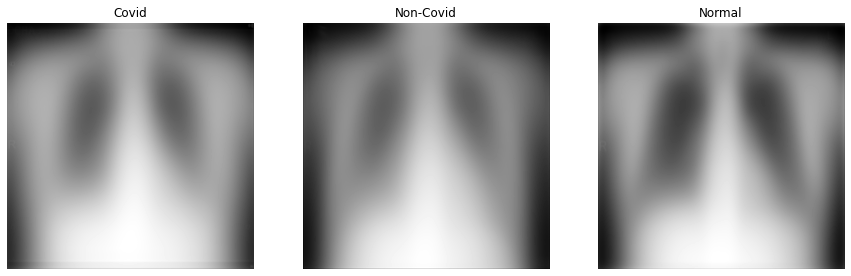

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 15))

ax1.imshow(Covid, cmap='gray')
ax1.axis('off')
ax1.set_title("Covid")
ax2.imshow(Non_Covid, cmap='gray')
ax2.axis('off')
ax2.set_title("Non-Covid")
ax3.imshow(Normal, cmap='gray')
ax3.axis('off')
ax3.set_title("Normal");

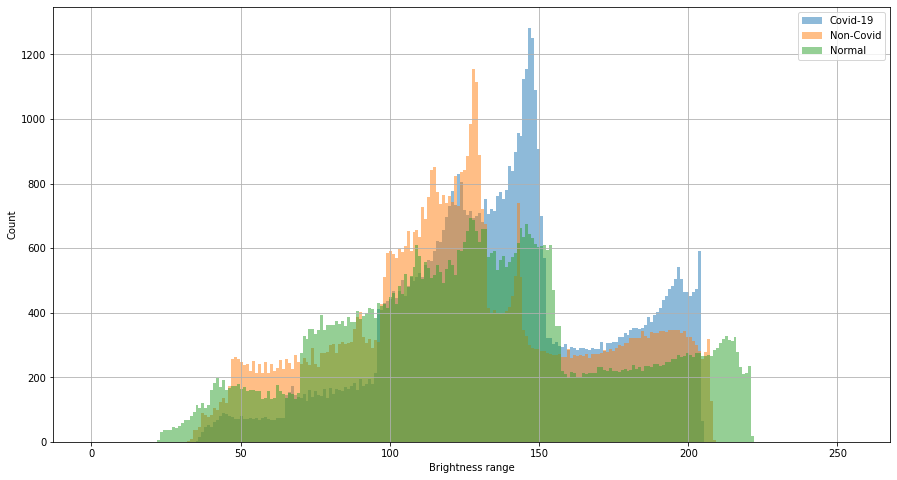

In [ ]:
# Plotting histograms
fig = plt.figure(figsize=(15, 8))
plt.hist(Covid.ravel(),bins=256,range=(0, 255), alpha=0.5, label='Covid-19')
plt.hist(Non_Covid.ravel(),bins=256,range=(0, 255),  alpha=0.5, label='Non-Covid')
plt.hist(Normal.ravel(),bins=256, range=(0, 255), alpha=0.5, label='Normal')

# Adding legend
plt.legend()
plt.grid(True)
plt.xlabel("Brightness range")
plt.ylabel("Count")
# Displaying plot
plt.show()

####equalized images

In [ ]:
Covid_equalized=stat_cov_e["mean"][0]
Non_Covid_equalized=stat_non_e["mean"][0]
Normal_equalized=stat_norm_e["mean"][0]

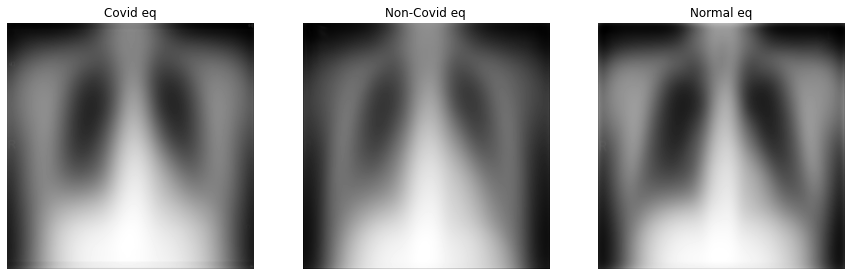

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 15))

ax1.imshow(Covid_equalized, cmap='gray')
ax1.axis('off')
ax1.set_title("Covid eq")
ax2.imshow(Non_Covid_equalized, cmap='gray')
ax2.axis('off')
ax2.set_title("Non-Covid eq")
ax3.imshow(Normal_equalized, cmap='gray')
ax3.axis('off')
ax3.set_title("Normal eq");

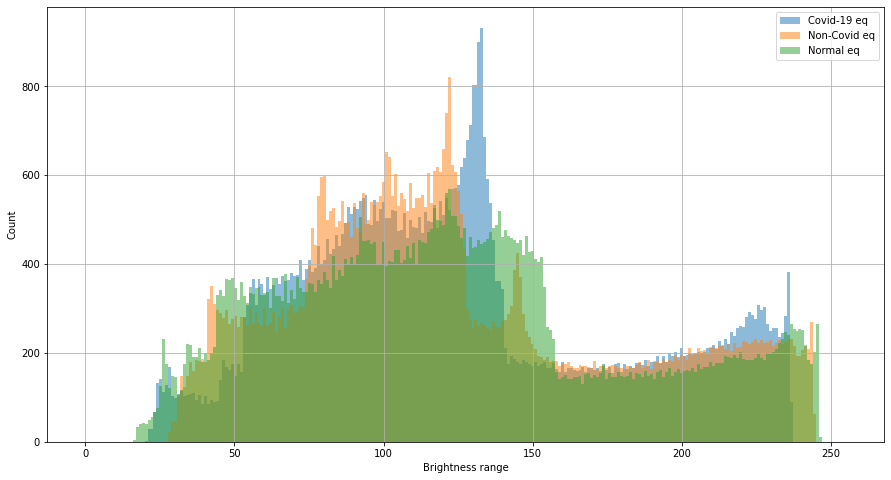

In [ ]:
# Plotting histograms
fig = plt.figure(figsize=(15, 8))
plt.hist(Covid_equalized.ravel(),bins=256,range=(0, 255), alpha=0.5, label='Covid-19 eq')
plt.hist(Non_Covid_equalized.ravel(),bins=256,range=(0, 255),  alpha=0.5, label='Non-Covid eq')
plt.hist(Normal_equalized.ravel(),bins=256, range=(0, 255), alpha=0.5, label='Normal eq')

# Adding legend
plt.legend()
plt.grid(True)
plt.xlabel("Brightness range")
plt.ylabel("Count")

# Displaying plot
plt.show()

####cropped mask images

In [ ]:
Covid_mask=stat_cov_mask["mean"][0]
Non_Covid_mask=stat_non_mask["mean"][0]
Normal_mask=stat_norm_mask["mean"][0]

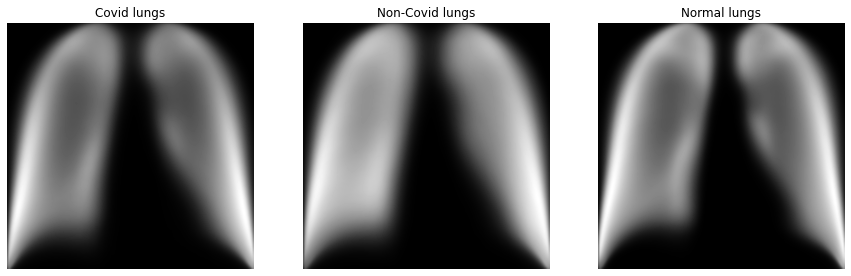

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 15))

ax1.imshow(Covid_mask, cmap='gray')
ax1.axis('off')
ax1.set_title("Covid lungs")
ax2.imshow(Non_Covid_mask, cmap='gray')
ax2.axis('off')
ax2.set_title("Non-Covid lungs")
ax3.imshow(Normal_mask, cmap='gray')
ax3.axis('off')
ax3.set_title("Normal lungs");

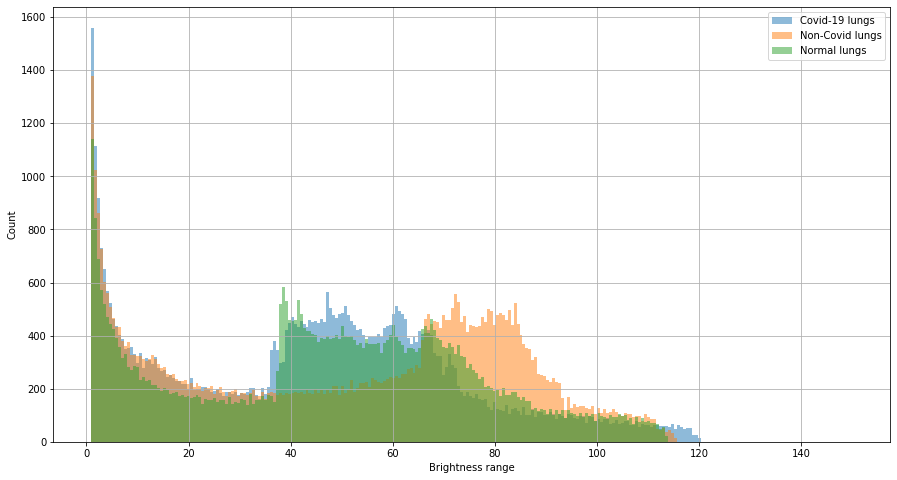

In [ ]:
# Plotting histograms
fig = plt.figure(figsize=(15, 8))
plt.hist(Covid_mask.ravel(),bins=256,range=(1, 150), alpha=0.5, label='Covid-19 lungs')
plt.hist(Non_Covid_mask.ravel(),bins=256,range=(1, 150),  alpha=0.5, label='Non-Covid lungs')
plt.hist(Normal_mask.ravel(),bins=256, range=(1, 150), alpha=0.5, label='Normal lungs')

# Adding legend
plt.legend()
plt.grid(True)
plt.xlabel("Brightness range")
plt.ylabel("Count")
# Displaying plot
plt.show()

## Visualization of mean, std, median, q0.25, q0.75 images and pixel intensity distribution

### function

In [ ]:
#######creating global mean, std, median, q1, q3 into a df adding pix_int_dist#######

def reshape_df_img(column, dfclass):
  X= []
  for i in column:
    X.append(i)
  X = np.array(X).reshape(-1, 256, 256, 1)
  x = X.reshape(len(column), 256*256)
  b=pd.DataFrame(x)
  mean=b.mean()
  std=b.std()
  median= b.median()
  q1= b.quantile(0.25)
  q3= b.quantile(0.75)

  m=np.array(mean).reshape(256, 256)
  s=np.array(std).reshape(256, 256)
  m2=np.array(median).reshape(256, 256)
  q1=np.array(q1).reshape(256, 256)
  q3=np.array(q3).reshape(256, 256)
  
  liste=[m,s,m2,q1,q3]
  y=[]
  for i in liste:
    i=pix_int_dist(i)
    y.append(i)

  data={'class':dfclass,'mean':[m],'std':[s],'median':[m2],'q0.25':[q1],'q0.75':[q3]}
  data2={'class':"pix_int_dist",'mean':[y[0]],'std':[y[1]],'median':[y[2]],'q0.25':[y[3]],'q0.75':[y[4]]}
  
  df_stats = pd.DataFrame(data, index=[0])
  df_dist = pd.DataFrame(data2, index=[0])
  df_stat=pd.concat([df_stats,df_dist],ignore_index=True)
  return df_stat

In [ ]:
####pixel intensity distribution#####

def pix_int_dist(x):
    pixel_intensity_distribution = ndimage.histogram((x), min=np.min(x), max=np.max(x), bins=256)
    return pixel_intensity_distribution 

In [ ]:
####displaying the stats####

def display_stat(dataset ):  
  
  plt.figure(figsize = (16,8))
  
  plt.subplot(2,5,1)
  plt.imshow(dataset["mean"][0], cmap = 'gray')
  plt.title("mean")
  plt.subplot(2,5,2)
  plt.imshow(dataset["std"][0], cmap = 'gray')
  plt.title("std")
  plt.subplot(2,5,3) 
  plt.imshow(dataset["median"][0], cmap = 'gray')
  plt.title("median")
  plt.subplot(2,5,4)
  plt.imshow(dataset["q0.25"][0], cmap = 'gray' )
  plt.title("q0.25")
  plt.subplot(2,5,5)
  plt.imshow(dataset["q0.75"][0], cmap = 'gray' )
  plt.title("q0.75")
  
  plt.subplot(2,5,6)
  plt.plot(dataset["mean"][1])
  plt.title("pix_int_dist")
  plt.subplot(2,5,7) 
  plt.plot(dataset["std"][1])
  plt.title("pix_int_dist")
  plt.subplot(2,5,8)
  plt.plot(dataset["median"][1] )
  plt.title("pix_int_dist")
  plt.subplot(2,5,9)
  plt.plot(dataset["q0.25"][1] )
  plt.title("pix_int_dist")
  plt.subplot(2,5,10)
  plt.plot(dataset["q0.75"][1], )
  plt.title("pix_int_dist")
  return plt.show


  #####saving the graphs

  plt.savefig("/content/drive/MyDrive/saves/df_stat.png")

### Plot for infection segmentation data covid

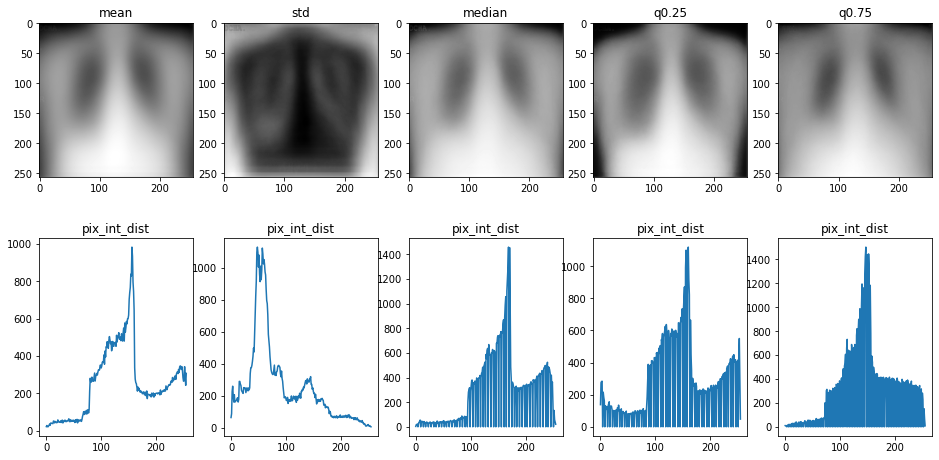

In [ ]:
display_all(stat_cov)


#Showing Biases with simple models

## unpreprocessed images

###training part

#### generator infection segmentation

In [ ]:
seed=42
dir_imgs_train = '/content/data/Infection Segmentation Data/Train'
dir_imgs_val = '/content/data/Infection Segmentation Data/Val'
dir_imgs_test = '/content/data/Infection Segmentation Data/Test'
c_mode = "grayscale"
imsize = 16
batch_size=32

train_data_generator = ImageDataGenerator()
                                   

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize), 
                                                           color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 3728 images belonging to 3 classes.
Found 932 images belonging to 3 classes.
Found 1166 images belonging to 3 classes.


####model

In [ ]:

# CNN-Model
model = tf.keras.Sequential()

#  convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding = 'same', input_shape=(imsize, imsize, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = 'same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))



# fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))


# Compile the model
lr=0.001
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_11 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                      

####train infection segmentation

In [ ]:
initial_learning_rate = 0.002
steps= 5
decay=0.6
min_delta=0
patience=8
monitor="val_loss"
epochs=60

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train_generator, validation_data = val_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper])             

Epoch 1/60
117/117 [==============================] - 27s 207ms/step - loss: 1.0245 - accuracy: 0.5738 - val_loss: 0.8777 - val_accuracy: 0.6009 - lr: 0.0020
Epoch 2/60
117/117 [==============================] - 16s 138ms/step - loss: 0.7982 - accuracy: 0.6518 - val_loss: 0.6896 - val_accuracy: 0.7167 - lr: 0.0020
Epoch 3/60
117/117 [==============================] - 18s 158ms/step - loss: 0.7382 - accuracy: 0.6709 - val_loss: 0.6263 - val_accuracy: 0.7618 - lr: 0.0020
Epoch 4/60
117/117 [==============================] - 15s 132ms/step - loss: 0.6830 - accuracy: 0.6878 - val_loss: 0.7681 - val_accuracy: 0.6749 - lr: 0.0020
Epoch 5/60
117/117 [==============================] - 24s 208ms/step - loss: 0.6571 - accuracy: 0.7063 - val_loss: 0.6958 - val_accuracy: 0.7049 - lr: 0.0020
Epoch 6/60
117/117 [==============================] - 12s 98ms/step - loss: 0.5963 - accuracy: 0.7197 - val_loss: 0.7690 - val_accuracy: 0.6760 - lr: 0.0012
Epoch 7/60
117/117 [==============================] -

####generator lung segmentation

In [ ]:
seed=42
dir_imgs_train = '/content/data/Lung Segmentation Data/Train'
dir_imgs_val = '/content/data/Lung Segmentation Data/Val'
dir_imgs_test = '/content/data/Lung Segmentation Data/Test'
c_mode = "grayscale"
imsize = 16
batch_size=32

train_data_generator = ImageDataGenerator()
                                   

train2_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize), 
                                                           color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val2_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test2_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


####train lung segmentation

In [ ]:
initial_learning_rate = 0.002
steps= 5
decay=0.6
min_delta=0
patience=8
monitor="val_loss"
epochs=60

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train2_generator,validation_data = val2_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper])

Epoch 1/60
679/679 [==============================] - 157s 225ms/step - loss: 0.7490 - accuracy: 0.6719 - val_loss: 0.7025 - val_accuracy: 0.7246 - lr: 0.0020
Epoch 2/60
679/679 [==============================] - 82s 121ms/step - loss: 0.6647 - accuracy: 0.7208 - val_loss: 0.5479 - val_accuracy: 0.7750 - lr: 0.0020
Epoch 3/60
679/679 [==============================] - 65s 96ms/step - loss: 0.6321 - accuracy: 0.7391 - val_loss: 0.5803 - val_accuracy: 0.7711 - lr: 0.0020
Epoch 4/60
679/679 [==============================] - 61s 90ms/step - loss: 0.6037 - accuracy: 0.7539 - val_loss: 0.5725 - val_accuracy: 0.7663 - lr: 0.0020
Epoch 5/60
679/679 [==============================] - 65s 95ms/step - loss: 0.5490 - accuracy: 0.7775 - val_loss: 0.5259 - val_accuracy: 0.7977 - lr: 0.0012
Epoch 6/60
679/679 [==============================] - 61s 90ms/step - loss: 0.5287 - accuracy: 0.7862 - val_loss: 0.4868 - val_accuracy: 0.8028 - lr: 0.0012
Epoch 7/60
679/679 [==============================] - 6

### evaluation

In [ ]:
test_pred = model.predict(test_generator)
# Evaluation 
score = model.evaluate(test_generator)
score

37/37 [==============================] - 2s 64ms/step - loss: 0.4178 - accuracy: 0.8473


[0.4177786707878113, 0.8473413586616516]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = test_generator.classes

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       583
           1       0.72      0.83      0.77       292
           2       0.82      0.85      0.83       291

    accuracy                           0.85      1166
   macro avg       0.83      0.84      0.83      1166
weighted avg       0.86      0.85      0.85      1166



[[499  58  26]
 [ 22 243  27]
 [  8  37 246]]


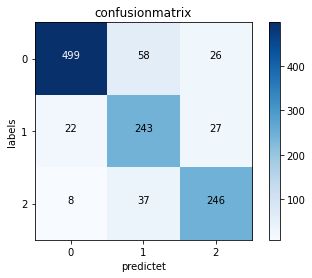

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)
classes = range(0,3)
plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()

###feature map

In [ ]:
imgs_batch= train_generator.next()
imgs_batch[1][0]
len(imgs_batch[0])

32

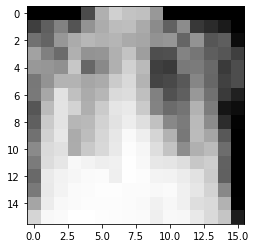

In [ ]:
index = 18
img= imgs_batch[0]
img = img[index]
img_d = img.reshape(imsize, imsize)
img = img_d[tf.newaxis, ...]
plt.imshow(img_d, cmap='gray')
plt.show()

In [ ]:
ixs = [0, 3, 5]
outputs = [model.layers[i].output for i in ixs]
feat_model = Model(inputs=model.inputs, outputs=outputs)
feat_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10_input (InputLayer  [(None, 16, 16, 1)]      0         
 )                                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          18496     
                                                             

In [ ]:
feature_maps = feat_model.predict(img)

1/1 [==============================] - 0s 171ms/step


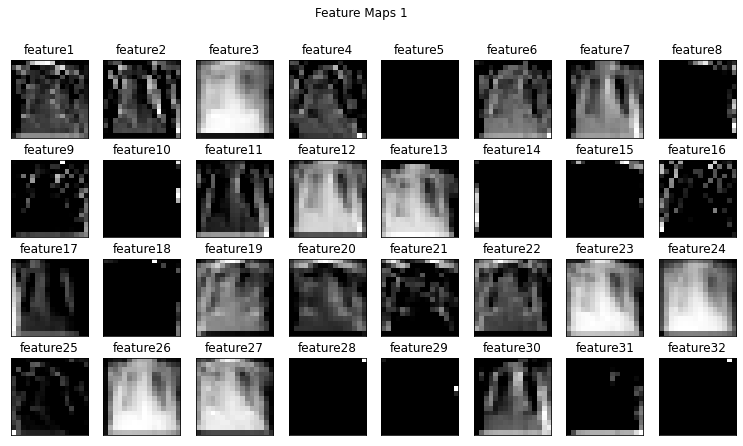

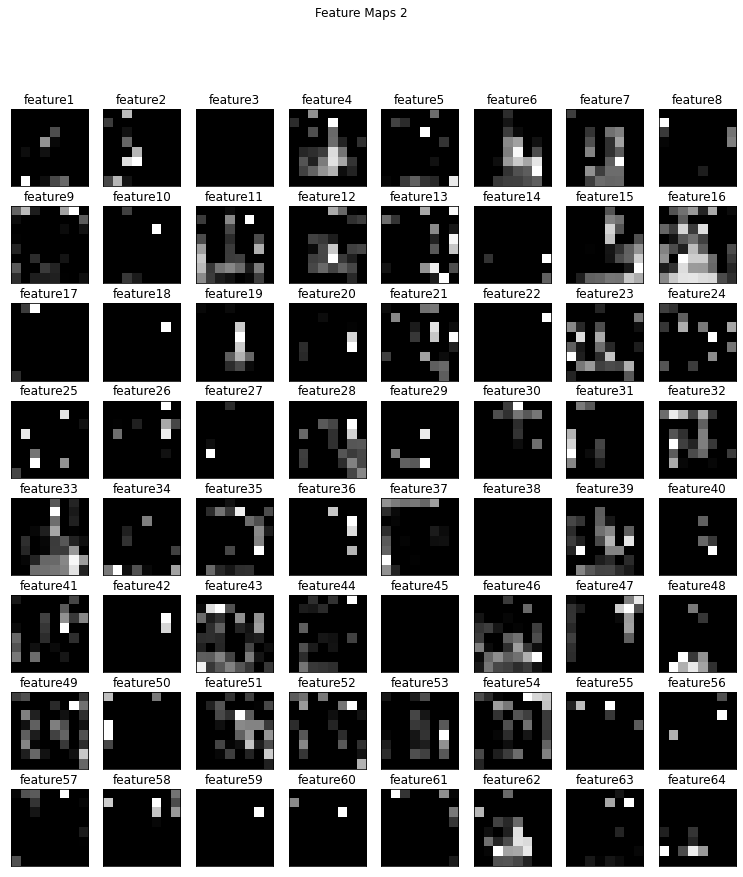

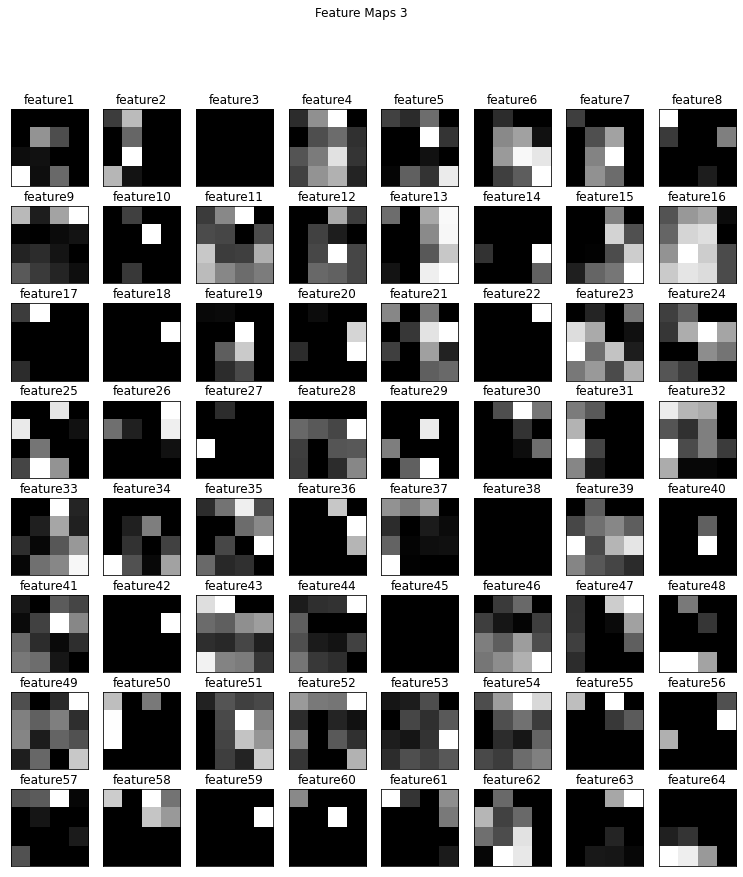

In [ ]:
count=1
for fmap in feature_maps:
    # plot all maps in an x8 squares
    ix = 1
    square = int((fmap.shape[-1])/8)
    square2 = 8
    if square <= 4:
        figsize = (13, 7)
    elif square <= 8:
        figsize = (13,14)
    elif square <= 16:
        figsize = (13, 28)   
    elif square <= 32:
        figsize = (13, 56)     
    plt.figure(figsize=figsize)
    plt.suptitle("Feature Maps " + str(count))
    for _ in range(square2):
        for _ in range(square):
            if (ix-1) < fmap.shape[-1]:
                ax = plt.subplot(square, square2, ix)
                ax.set_title("feature" + str(ix))
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1
            else:
                break
    count += 1 
    plt.show()

###heatmap batch

1/1 [==============================] - 0s 37ms/step


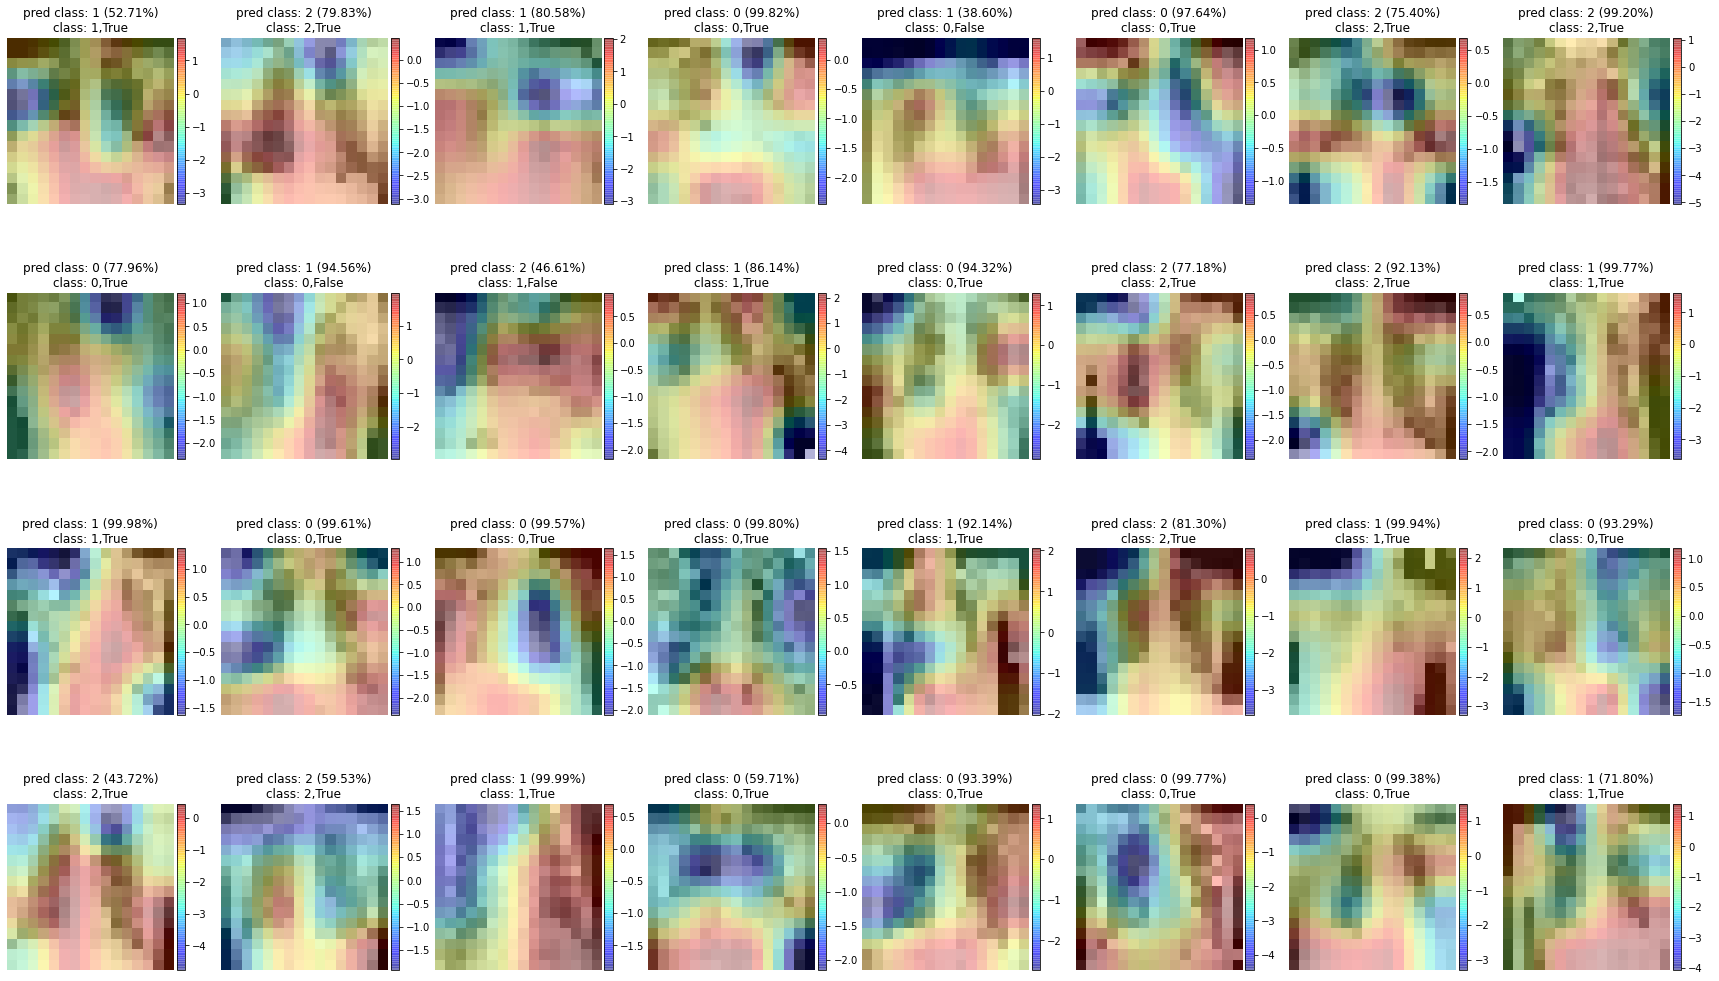

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
index = 31
img_class= imgs_batch[1]
img= imgs_batch[0]
img_t = img[index]
img_class_t = img_class[index]
img_t = img_t[tf.newaxis, ...]

batch=img
batch_class=img_class

last_conv_layer = model.get_layer('max_pooling2d_11')

model_fm = tf.keras.Model(inputs=model.inputs, outputs=[model.output,last_conv_layer.output])
num_rows = 4
num_cols = 8
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 18))

for c,(i,j) in enumerate(zip(batch, batch_class)):
  
  median_value = round(np.mean(i),0)
  i1 = i[tf.newaxis, ...]
  model_out, feature_maps = model_fm.predict(i1)
  feature_maps = np.squeeze(feature_maps)
  model_out = np.squeeze(model_out)
  weights = model.layers[-1].weights[0]
  max_idx = np.argmax( model_out )
  winning_weights = weights[:, max_idx]
  CAM = np.zeros(feature_maps.shape[:2])

  im_h, im_w = i.shape[:2]

  for k, wk in enumerate(winning_weights):
    # get feature map k
    feature_map_k = feature_maps[..., k]
    # get activation of map k (multiply Fk with wk)
    activation_k = feature_map_k * wk
    CAM += activation_k

  CAM=CAM.numpy()
  i1=i1.reshape(imsize,imsize)
  CAM.shape
  # resize CAM
  heatmap = cv2.resize(CAM, (i.shape[1], i.shape[0]))
  row = c // num_cols
  col = c % num_cols

  # Create an axes divider for the subplot
  divider = make_axes_locatable(axs[row, col])

  # Create the colorbar axis on the right of the subplot
  cax = divider.append_axes("right", size="5%", pad=0.05)

  axs[row, col].imshow(i1, alpha=1, cmap='gray')
  im=axs[row, col].imshow(heatmap, cmap='jet', alpha=0.3)
  title = f"pred class: {max_idx} ({model_out[max_idx]*100:.2f}%)\nclass: {np.argmax(j)},{max_idx==np.argmax(j)}"
  axs[row, col].set_title(title)
  axs[row, col].axis('off')
  fig.colorbar(im,cax=cax)
 


plt.show()

## equalized images

### train part

####generator infection segmentation

In [ ]:
seed=42
dir_imgs_train = '/content/data_equalize/Infection Segmentation Data/Train'
dir_imgs_val = '/content/data_equalize/Infection Segmentation Data/Val'
dir_imgs_test = '/content/data_equalize/Infection Segmentation Data/Test'
c_mode = "grayscale"
imsize = 16
batch_size=32

train_data_generator = ImageDataGenerator()
                                   

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize), 
                                                           color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 3728 images belonging to 3 classes.
Found 932 images belonging to 3 classes.
Found 1165 images belonging to 3 classes.


####model

In [ ]:

# CNN-Model
model = tf.keras.Sequential()

# convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding = 'same', input_shape=(imsize, imsize, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = 'same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))



#  connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))


# Compile the model
lr=0.001
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                        

####train infection segmentation

In [ ]:
initial_learning_rate = 0.002
steps= 5
decay=0.6
min_delta=0
patience=8
monitor="val_loss"
epochs=60

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train_generator, validation_data = val_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper])        

Epoch 1/60
117/117 [==============================] - 18s 138ms/step - loss: 0.6527 - accuracy: 0.7264 - val_loss: 0.8696 - val_accuracy: 0.6352 - lr: 0.0020
Epoch 2/60
117/117 [==============================] - 12s 100ms/step - loss: 0.5930 - accuracy: 0.7409 - val_loss: 0.7790 - val_accuracy: 0.6320 - lr: 0.0020
Epoch 3/60
117/117 [==============================] - 12s 102ms/step - loss: 0.5374 - accuracy: 0.7653 - val_loss: 0.7305 - val_accuracy: 0.6652 - lr: 0.0020
Epoch 4/60
117/117 [==============================] - 12s 104ms/step - loss: 0.5338 - accuracy: 0.7733 - val_loss: 0.7917 - val_accuracy: 0.6738 - lr: 0.0020
Epoch 5/60
117/117 [==============================] - 12s 103ms/step - loss: 0.5050 - accuracy: 0.7905 - val_loss: 0.7560 - val_accuracy: 0.6599 - lr: 0.0020
Epoch 6/60
117/117 [==============================] - 14s 117ms/step - loss: 0.4314 - accuracy: 0.8146 - val_loss: 0.9756 - val_accuracy: 0.5547 - lr: 0.0012
Epoch 7/60
117/117 [==============================] 

####generator lung segmentation

In [ ]:
seed=42
dir_imgs_train = '/content/data_equalize/Lung Segmentation Data/Train'
dir_imgs_val = '/content/data_equalize/Lung Segmentation Data/Val'
dir_imgs_test = '/content/data_equalize/Lung Segmentation Data/Test'
c_mode = "grayscale"
imsize = 16
batch_size=32

train_data_generator = ImageDataGenerator()
                                   

train2_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize), 
                                                           color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val2_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test2_generator = ImageDataGenerator().flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode='categorical',
                                                           target_size=(imsize,imsize),
                                                           color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 21715 images belonging to 3 classes.
Found 5416 images belonging to 3 classes.
Found 6787 images belonging to 3 classes.


#### train lung segmentation

In [ ]:
initial_learning_rate = 0.002
steps= 5
decay=0.6
min_delta=0
patience=8
monitor="val_loss"
epochs=60

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train2_generator, validation_data = val2_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper])        

Epoch 1/60
679/679 [==============================] - 110s 155ms/step - loss: 0.7423 - accuracy: 0.6841 - val_loss: 0.6491 - val_accuracy: 0.7411 - lr: 0.0020
Epoch 2/60
679/679 [==============================] - 49s 72ms/step - loss: 0.6637 - accuracy: 0.7269 - val_loss: 0.5924 - val_accuracy: 0.7742 - lr: 0.0020
Epoch 3/60
679/679 [==============================] - 52s 77ms/step - loss: 0.6311 - accuracy: 0.7376 - val_loss: 0.5881 - val_accuracy: 0.7784 - lr: 0.0020
Epoch 4/60
679/679 [==============================] - 49s 72ms/step - loss: 0.6061 - accuracy: 0.7543 - val_loss: 0.5425 - val_accuracy: 0.7847 - lr: 0.0020
Epoch 5/60
679/679 [==============================] - 49s 73ms/step - loss: 0.5551 - accuracy: 0.7752 - val_loss: 0.5677 - val_accuracy: 0.7716 - lr: 0.0012
Epoch 6/60
679/679 [==============================] - 48s 71ms/step - loss: 0.5263 - accuracy: 0.7869 - val_loss: 0.5694 - val_accuracy: 0.7716 - lr: 0.0012
Epoch 7/60
679/679 [==============================] - 48

###evaluation

In [ ]:
# Prediction de l'échantillon de test
test_pred = model.predict(test_generator)

# Evaluation du modèle
score = model.evaluate(test_generator)
score

37/37 [==============================] - 3s 70ms/step - loss: 0.4675 - accuracy: 0.8215


[0.46745485067367554, 0.8214592337608337]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = test_generator.classes

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       582
           1       0.71      0.81      0.76       292
           2       0.75      0.86      0.80       291

    accuracy                           0.82      1165
   macro avg       0.80      0.83      0.81      1165
weighted avg       0.84      0.82      0.82      1165



[[470  66  46]
 [ 16 237  39]
 [ 11  30 250]]


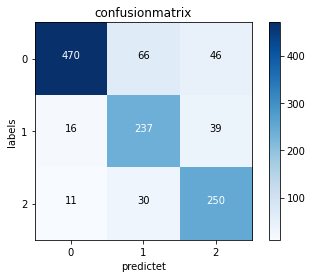

In [ ]:


cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)

classes = range(0,3)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()


###feature map

In [ ]:
imgs_batch= train_generator.next()
imgs_batch[1][0]
len(imgs_batch[0])

32

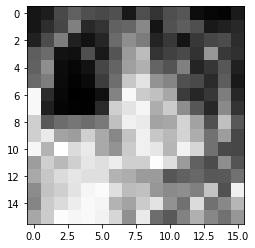

In [ ]:
index = 18
img= imgs_batch[0]
img = img[index]
img_d = img.reshape(imsize, imsize)
img = img_d[tf.newaxis, ...]
plt.imshow(img_d, cmap='gray')
plt.show()

In [ ]:
ixs = [0, 3, 5]
outputs = [model.layers[i].output for i in ixs]
feat_model = Model(inputs=model.inputs, outputs=outputs)
feat_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 16, 16, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256 

In [ ]:
feature_maps = feat_model.predict(img)

1/1 [==============================] - 0s 350ms/step


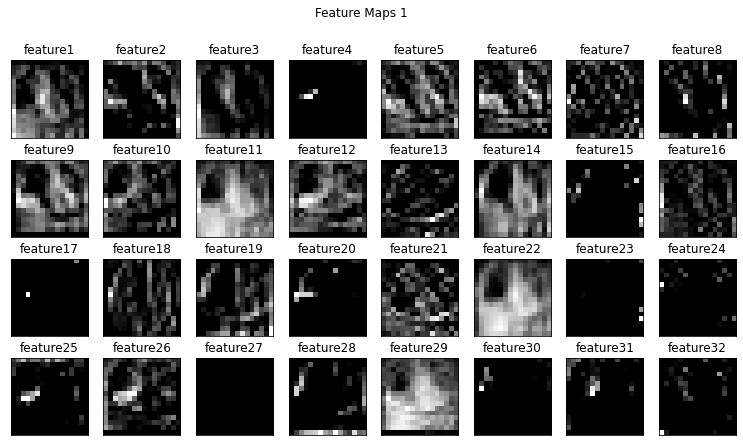

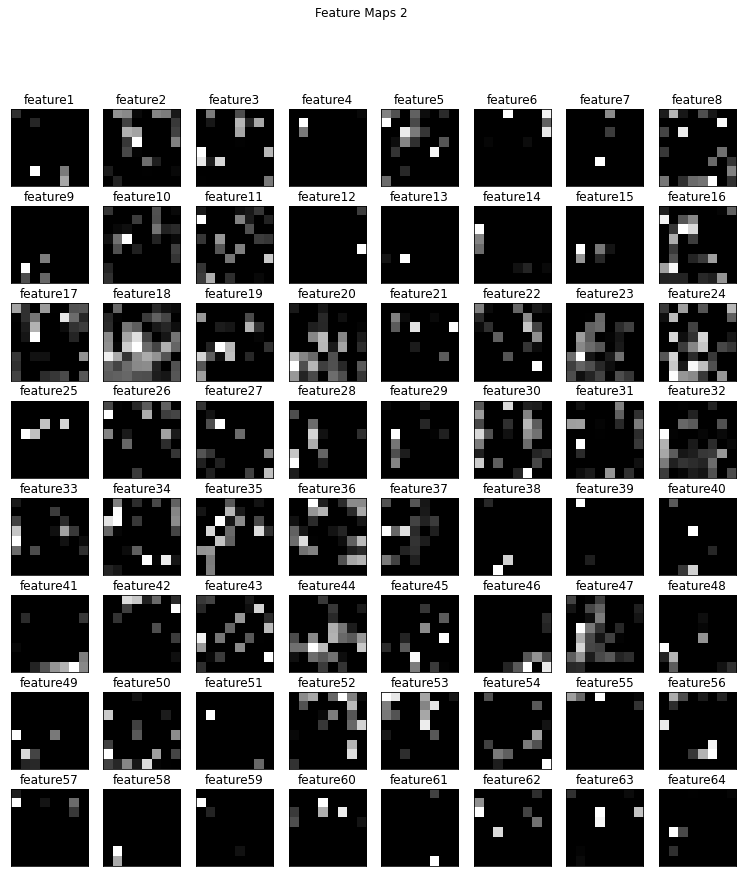

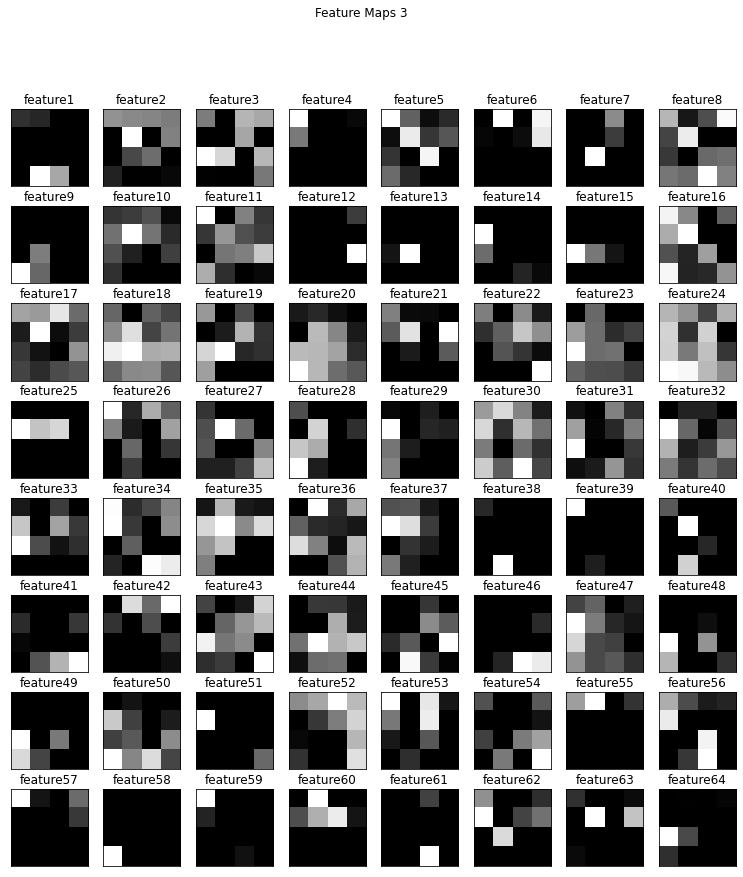

In [ ]:
count=1
for fmap in feature_maps:
    # plot all maps in an x8 squares
    ix = 1
    square = int((fmap.shape[-1])/8)
    square2 = 8
    if square <= 4:
        figsize = (13, 7)
    elif square <= 8:
        figsize = (13,14)
    elif square <= 16:
        figsize = (13, 28)   
    elif square <= 32:
        figsize = (13, 56)     
    plt.figure(figsize=figsize)
    plt.suptitle("Feature Maps " + str(count))
    for _ in range(square2):
        for _ in range(square):
            if (ix-1) < fmap.shape[-1]:
                ax = plt.subplot(square, square2, ix)
                ax.set_title("feature" + str(ix))
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1
            else:
                break
    count += 1 
    plt.show()

###heatmap batch

1/1 [==============================] - 0s 148ms/step


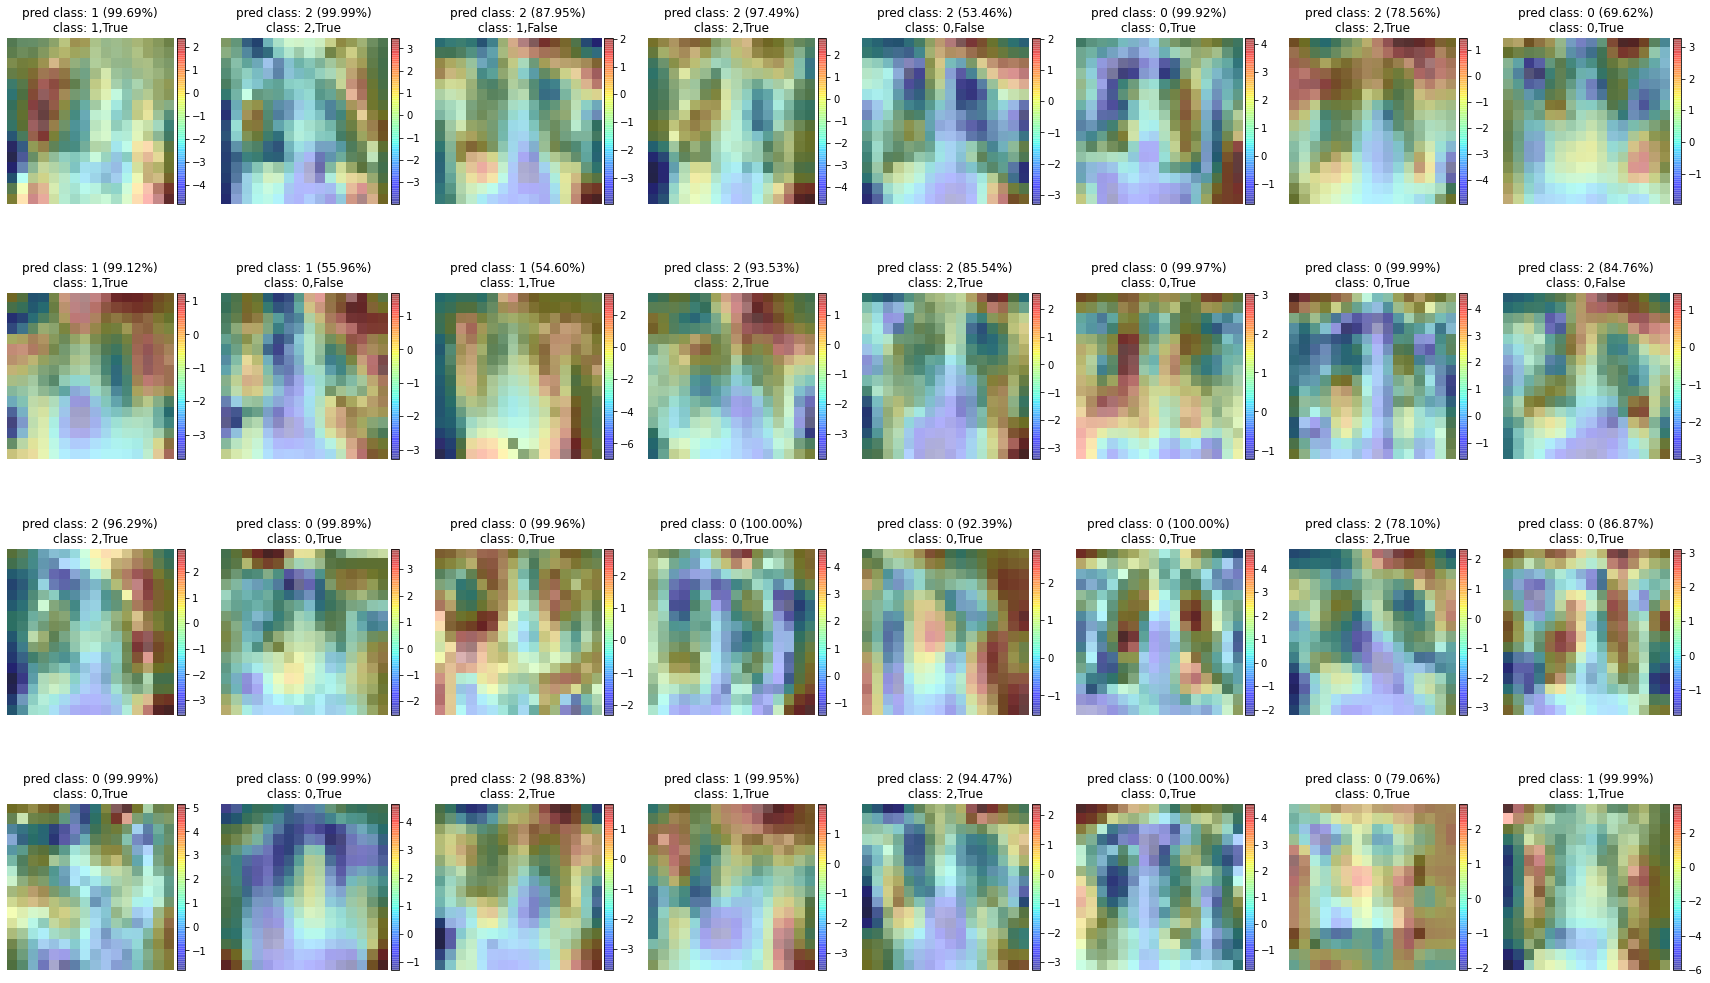

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
index = 31
img_class= imgs_batch[1]
img= imgs_batch[0]
img_t = img[index]
img_class_t = img_class[index]
img_t = img_t[tf.newaxis, ...]

batch=img
batch_class=img_class

last_conv_layer = model.get_layer('max_pooling2d_1')

model_fm = tf.keras.Model(inputs=model.inputs, outputs=[model.output,last_conv_layer.output])
num_rows = 4
num_cols = 8
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 18))

for c,(i,j) in enumerate(zip(batch, batch_class)):
  
  median_value = round(np.mean(i),0)
  i1 = i[tf.newaxis, ...]
  model_out, feature_maps = model_fm.predict(i1)
  feature_maps = np.squeeze(feature_maps)
  model_out = np.squeeze(model_out)
  weights = model.layers[-1].weights[0]
  max_idx = np.argmax( model_out )
  winning_weights = weights[:, max_idx]
  CAM = np.zeros(feature_maps.shape[:2])

  im_h, im_w = i.shape[:2]

  for k, wk in enumerate(winning_weights):
    # get feature map k
    feature_map_k = feature_maps[..., k]
    # get activation of map k (multiply Fk with wk)
    activation_k = feature_map_k * wk
    CAM += activation_k

  CAM=CAM.numpy()
  i1=i1.reshape(imsize,imsize)
  CAM.shape
  # resize CAM
  heatmap = cv2.resize(CAM, (i.shape[1], i.shape[0]))
  row = c // num_cols
  col = c % num_cols

  # Create an axes divider for the subplot
  divider = make_axes_locatable(axs[row, col])

  # Create the colorbar axis on the right of the subplot
  cax = divider.append_axes("right", size="5%", pad=0.05)

  axs[row, col].imshow(i1, alpha=1, cmap='gray')
  im=axs[row, col].imshow(heatmap, cmap='jet', alpha=0.3)
  title = f"pred class: {max_idx} ({model_out[max_idx]*100:.2f}%)\nclass: {np.argmax(j)},{max_idx==np.argmax(j)}"
  axs[row, col].set_title(title)
  axs[row, col].axis('off')
  fig.colorbar(im,cax=cax)
 
plt.show()

##augmented equalized images

###train part

####generator infection segmentation

In [ ]:
seed=42
dir_imgs_train = '/content/data_equalize/Infection Segmentation Data/Train'
dir_imgs_val = '/content/data_equalize/Infection Segmentation Data/Val'
dir_imgs_test = '/content/data_equalize/Infection Segmentation Data/Test'
c_mode = "grayscale"
imsize = 16
batch_size=64

def custom_augmentation(np_tensor):
  np_tensor=np_tensor/255
  def random_contrast(np_tensor):
    return tf.clip_by_value(tf.image.random_contrast(np_tensor, 0.9,1),0,1)
    
  def random_brightness(np_tensor):        
    return tf.clip_by_value(tf.image.random_brightness(np_tensor,(0.2)),0,1)
 
  def random_gamma(np_tensor):
    gamma = tf.random.uniform([1], 0.9, 1)
    return tf.clip_by_value(tf.image.adjust_gamma(np_tensor, gamma),0,1)  

  def gaussian(np_tensor):
    np_tensor = tf.clip_by_value(gaussian_filter(np_tensor, sigma=0.5),0,1)
    return np_tensor

  np_tensor = random_gamma(np_tensor)
  np_tensor = random_brightness(np_tensor)     
  np_tensor = random_contrast(np_tensor)  
  np_tensor =gaussian(np_tensor)
  return np_tensor



train_data_generator = ImageDataGenerator(fill_mode='constant', cval=0,
                                         #rescale=1./255, 
                                         preprocessing_function = custom_augmentation,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2,
                                         rotation_range=20)

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize), 
                                                           #color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 3728 images belonging to 3 classes.
Found 932 images belonging to 3 classes.
Found 1165 images belonging to 3 classes.


IndexError: ignored

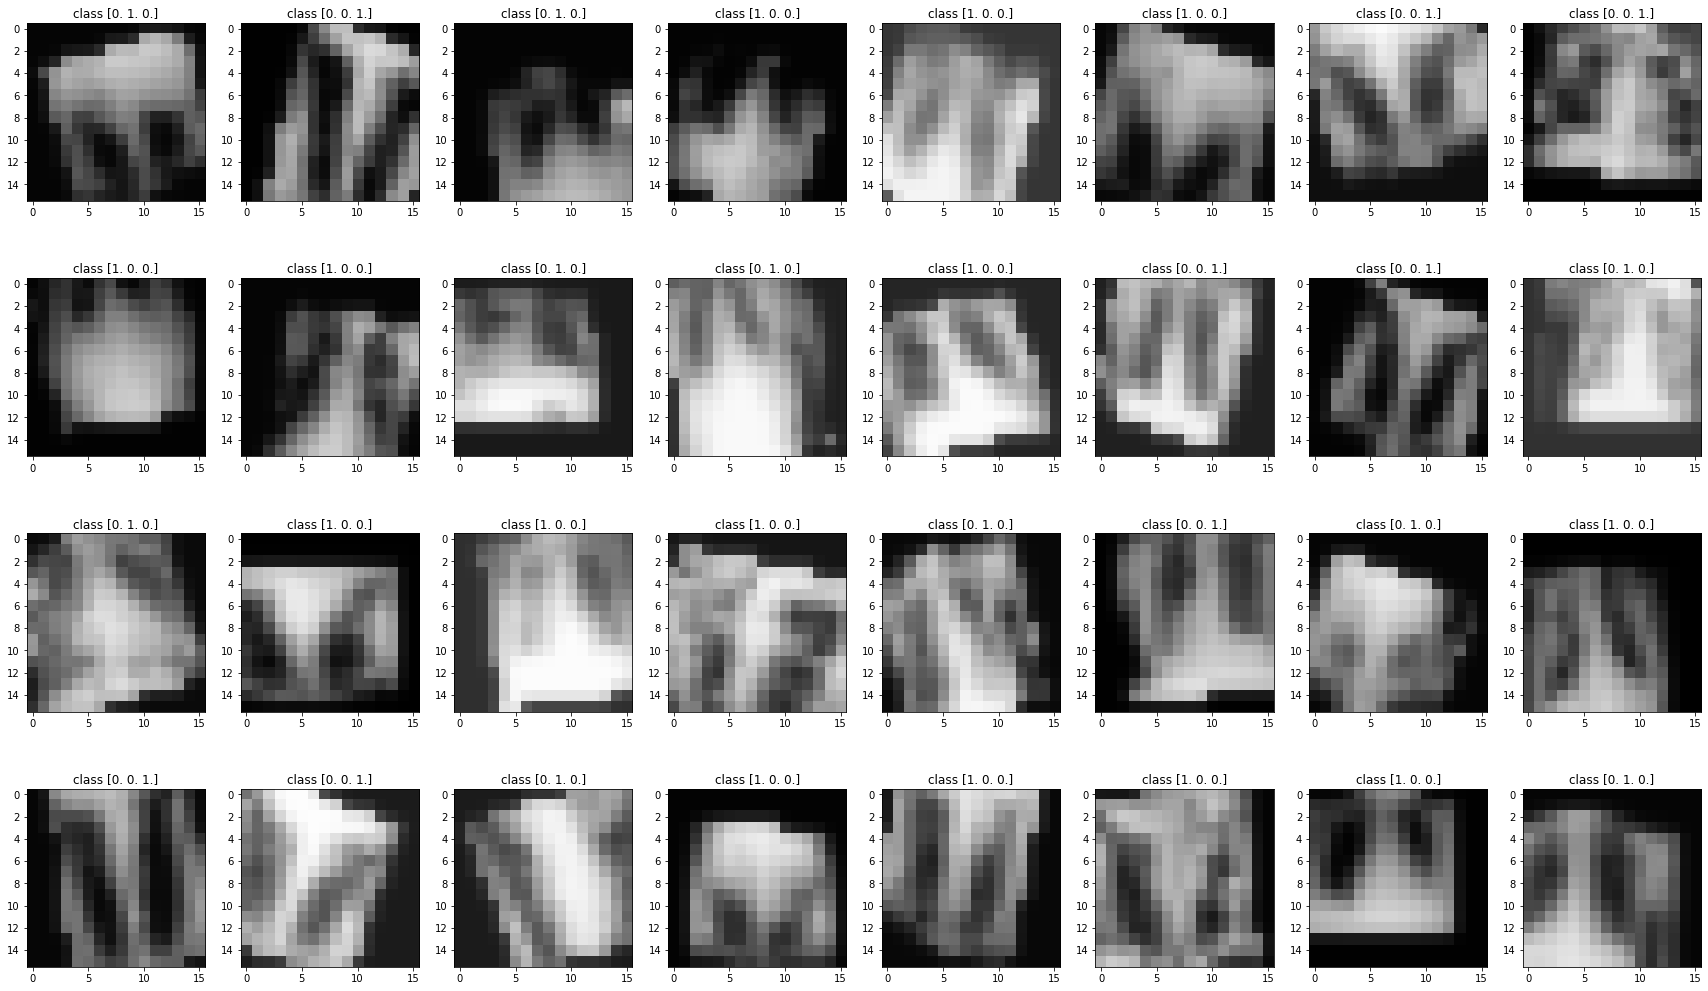

In [ ]:
#Image Data Generator testing/tuning
imgs_batch= train_generator.next()
num_rows = 4
num_cols = 8
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 18))
for i, (img,img_class) in enumerate(zip(imgs_batch[0],imgs_batch[1])):
    row = i // num_cols
    col = i % num_cols
    #img = img.reshape((imsize,imsize))
    axs[row, col].imshow(img, cmap='gray')
    axs[row,col].set_title("class " + str(img_class));
plt.show()

#### model

In [ ]:

# CNN-Model
model = tf.keras.Sequential()

# convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same",input_shape=(imsize, imsize,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3),padding="same", activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))


# fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))


# Compile the model
lr=0.001    
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                      

####train infection segmentation

In [ ]:
initial_learning_rate = 0.002
steps= 4
decay=0.6
min_delta=0
patience=8
monitor="val_loss"
epochs=10

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train_generator, validation_data = val_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper])   

Epoch 1/10
59/59 [==============================] - 60s 976ms/step - loss: 1.2128 - accuracy: 0.4619 - val_loss: 1.1012 - val_accuracy: 0.3026 - lr: 0.0020
Epoch 2/10
59/59 [==============================] - 34s 573ms/step - loss: 1.0448 - accuracy: 0.4965 - val_loss: 1.1907 - val_accuracy: 0.3509 - lr: 0.0020
Epoch 3/10
59/59 [==============================] - 34s 574ms/step - loss: 1.0288 - accuracy: 0.5059 - val_loss: 1.1559 - val_accuracy: 0.4410 - lr: 0.0020
Epoch 4/10
59/59 [==============================] - 29s 482ms/step - loss: 1.0195 - accuracy: 0.5051 - val_loss: 1.6110 - val_accuracy: 0.3015 - lr: 0.0020
Epoch 5/10
59/59 [==============================] - 26s 440ms/step - loss: 1.0035 - accuracy: 0.5207 - val_loss: 1.0905 - val_accuracy: 0.4109 - lr: 0.0012
Epoch 6/10
59/59 [==============================] - 23s 386ms/step - loss: 0.9966 - accuracy: 0.5153 - val_loss: 0.9512 - val_accuracy: 0.5279 - lr: 0.0012
Epoch 7/10
59/59 [==============================] - 24s 403ms/st

####generator lung segmentation

In [ ]:
seed=42
dir_imgs_train = '/content/data_equalize/Lung Segmentation Data/Train'
dir_imgs_val = '/content/data_equalize/Lung Segmentation Data/Val'
dir_imgs_test = '/content/data_equalize/Lung Segmentation Data/Test'
c_mode = "grayscale"
imsize = 16
batch_size=64

def custom_augmentation(np_tensor):
  np_tensor=np_tensor/255
  def random_contrast(np_tensor):
    return tf.clip_by_value(tf.image.random_contrast(np_tensor, 0.9,1),0,1)
    
  def random_brightness(np_tensor):        
    return tf.clip_by_value(tf.image.random_brightness(np_tensor,(0.2)),0,1)
 
  def random_gamma(np_tensor):
    gamma = tf.random.uniform([1], 0.9, 1)
    return tf.clip_by_value(tf.image.adjust_gamma(np_tensor, gamma),0,1)  

  def gaussian(np_tensor):
    np_tensor = tf.clip_by_value(gaussian_filter(np_tensor, sigma=0.5),0,1)
    return np_tensor

  np_tensor = random_gamma(np_tensor)
  np_tensor = random_brightness(np_tensor)     
  np_tensor = random_contrast(np_tensor)  
  np_tensor =gaussian(np_tensor)
  return np_tensor

train_data_generator = ImageDataGenerator(fill_mode='constant', cval=0,
                                         #rescale=1./255, 
                                         preprocessing_function = custom_augmentation,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2,
                                         rotation_range=20)

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize), 
                                                           #color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 21715 images belonging to 3 classes.
Found 5416 images belonging to 3 classes.
Found 6787 images belonging to 3 classes.


####train lungsegmentation

In [ ]:
initial_learning_rate = 0.002
steps= 4
decay=0.6
min_delta=0
patience=8
monitor="val_loss"
epochs=10

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train_generator, validation_data = val_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper])   

Epoch 1/10
340/340 [==============================] - 190s 544ms/step - loss: 1.0098 - accuracy: 0.4585 - val_loss: 1.3694 - val_accuracy: 0.3813 - lr: 0.0020
Epoch 2/10
340/340 [==============================] - 141s 414ms/step - loss: 0.9872 - accuracy: 0.4804 - val_loss: 1.0974 - val_accuracy: 0.4348 - lr: 0.0020
Epoch 3/10
340/340 [==============================] - 135s 397ms/step - loss: 0.9782 - accuracy: 0.4843 - val_loss: 1.0369 - val_accuracy: 0.4537 - lr: 0.0020
Epoch 4/10
340/340 [==============================] - 136s 399ms/step - loss: 0.9736 - accuracy: 0.4800 - val_loss: 1.2504 - val_accuracy: 0.3911 - lr: 0.0020
Epoch 5/10
340/340 [==============================] - 138s 407ms/step - loss: 0.9656 - accuracy: 0.4853 - val_loss: 1.1855 - val_accuracy: 0.3901 - lr: 0.0012
Epoch 6/10
340/340 [==============================] - 137s 402ms/step - loss: 0.9550 - accuracy: 0.5018 - val_loss: 1.0698 - val_accuracy: 0.4721 - lr: 0.0012
Epoch 7/10
340/340 [==========================

###evaluation infection segmentation

In [ ]:
test_pred = model.predict(test_generator)
# Evaluation 
score = model.evaluate(test_generator)
score

19/19 [==============================] - 4s 195ms/step - loss: 0.9847 - accuracy: 0.5167


[0.984727680683136, 0.5167381763458252]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = test_generator.classes

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       582
           1       0.95      0.07      0.13       292
           2       0.00      0.00      0.00       291

    accuracy                           0.52      1165
   macro avg       0.49      0.36      0.27      1165
weighted avg       0.49      0.52      0.37      1165



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[581   1   0]
 [271  21   0]
 [291   0   0]]


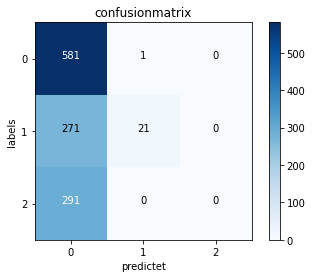

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)
classes = range(0,3)
plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()

###evaluation lung segmentation

In [ ]:
test_pred = model.predict(test_generator)
# Evaluation
score = model.evaluate(test_generator)
score

107/107 [==============================] - 25s 231ms/step - loss: 1.0578 - accuracy: 0.4806


[1.057765007019043, 0.4806247353553772]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = test_generator.classes

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.42      0.94      0.58      2394
           1       0.89      0.28      0.43      2253
           2       0.54      0.18      0.27      2140

    accuracy                           0.48      6787
   macro avg       0.62      0.47      0.43      6787
weighted avg       0.61      0.48      0.43      6787



[[2242   68   84]
 [1380  634  239]
 [1741   13  386]]


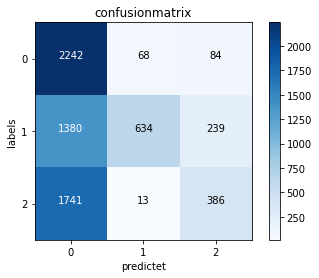

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)
classes = range(0,3)
plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()

###feature map

In [ ]:
imgs_batch= test_generator.next()
imgs_batch[1][0]
len(imgs_batch[0])

64

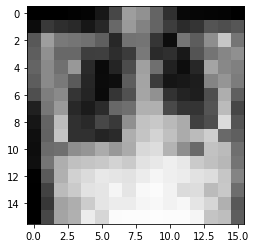

In [ ]:
index = 18
img= imgs_batch[0]
img = img[index]
img_d = img.reshape(imsize, imsize,3)
img_t = img_d[tf.newaxis, ...]
plt.imshow(img_d, cmap='gray')
plt.show()

In [ ]:
ixs = [0, 3, 5]
outputs = [model.layers[i].output for i in ixs]
feat_model = Model(inputs=model.inputs, outputs=outputs)
feat_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 16, 16, 3)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256

In [ ]:
feature_maps = feat_model.predict(img)

1/1 [==============================] - 0s 168ms/step


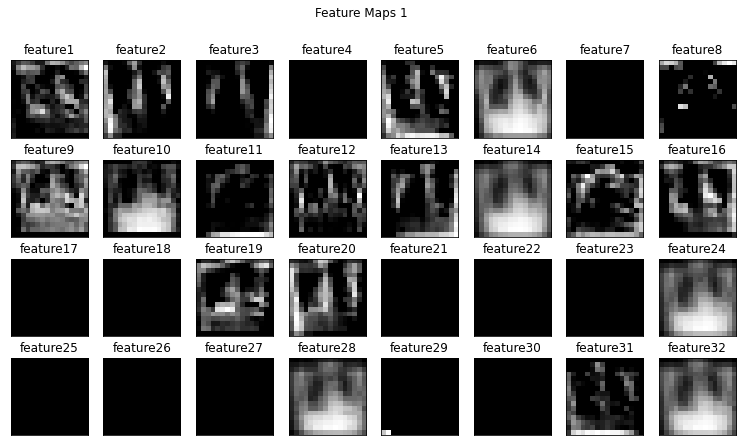

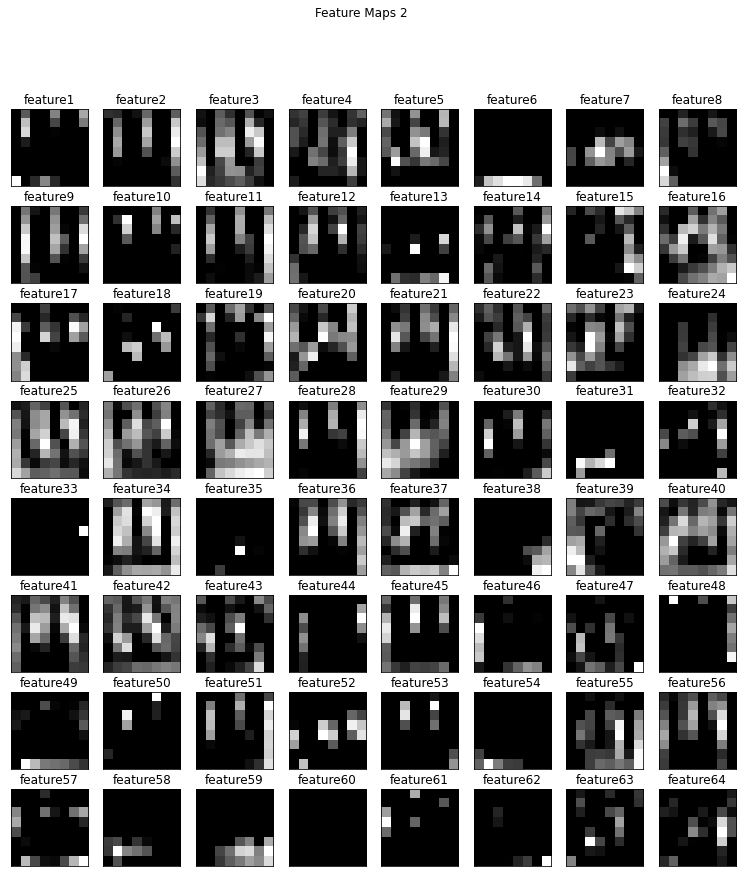

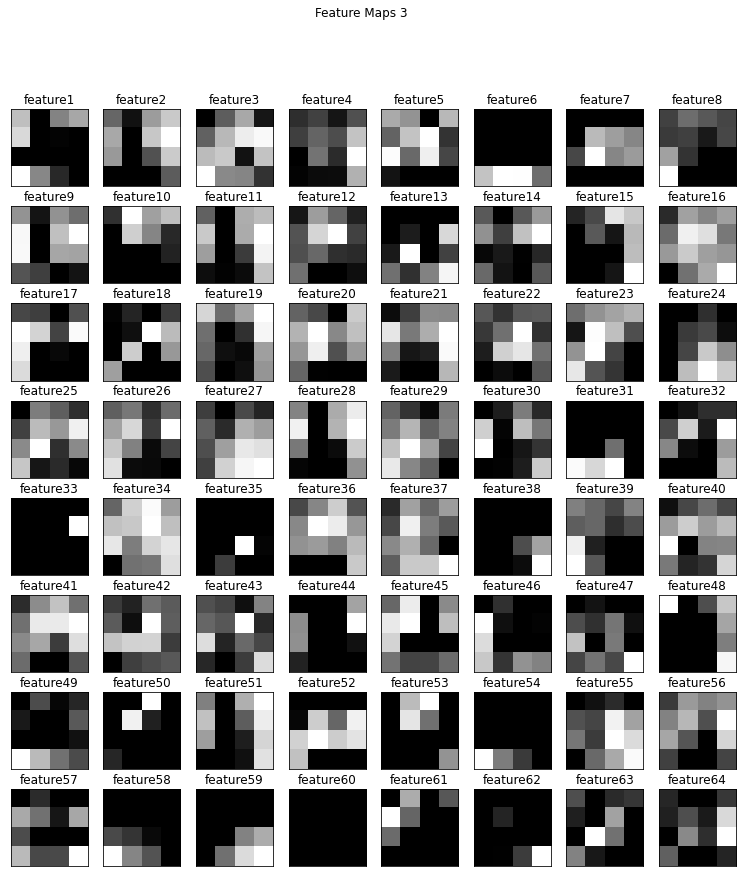

In [ ]:
count=1
for fmap in feature_maps:
    # plot all maps in an x8 squares
    ix = 1
    square = int((fmap.shape[-1])/8)
    square2 = 8
    if square <= 4:
        figsize = (13, 7)
    elif square <= 8:
        figsize = (13,14)
    elif square <= 16:
        figsize = (13, 28)   
    elif square <= 32:
        figsize = (13, 56)     
    plt.figure(figsize=figsize)
    plt.suptitle("Feature Maps " + str(count))
    for _ in range(square2):
        for _ in range(square):
            if (ix-1) < fmap.shape[-1]:
                ax = plt.subplot(square, square2, ix)
                ax.set_title("feature" + str(ix))
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1
            else:
                break
    count += 1 
    plt.show()

###heatmap batch

1/1 [==============================] - 0s 99ms/step


IndexError: ignored

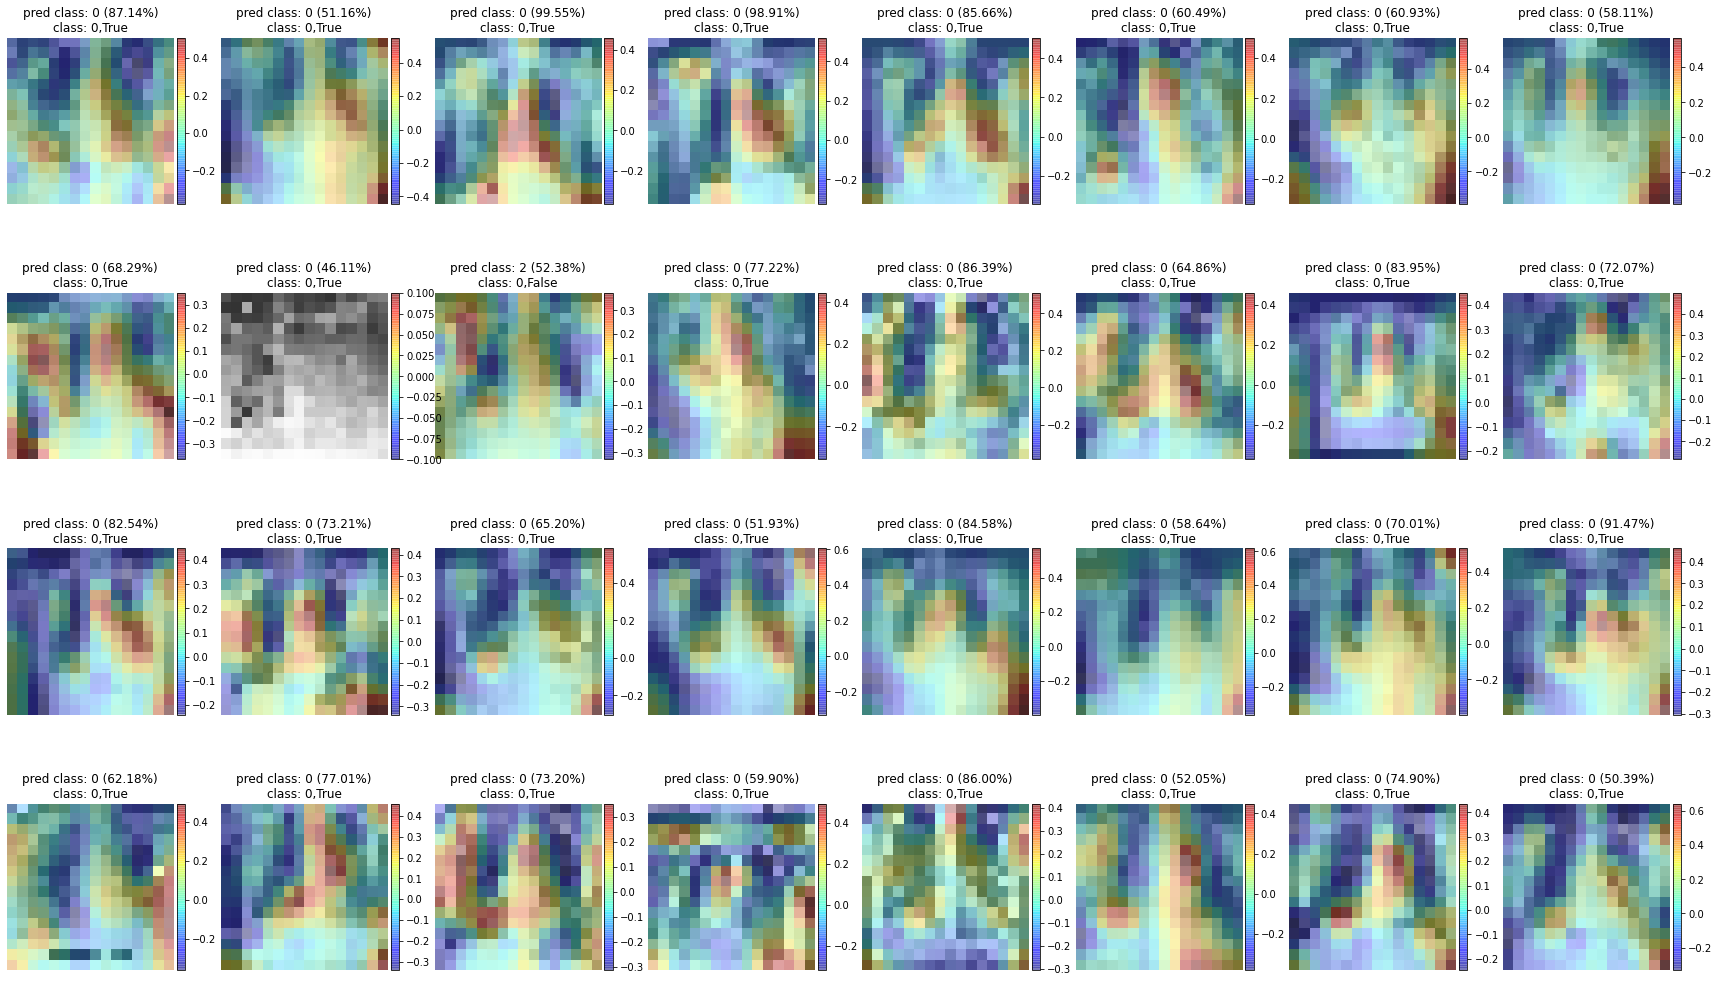

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
index = 31
img_class= imgs_batch[1]
img= imgs_batch[0]
img_t = img[index]
img_class_t = img_class[index]
img_t = img_t[tf.newaxis, ...]

batch=img
batch_class=img_class

last_conv_layer = model.get_layer('max_pooling2d_5')

model_fm = tf.keras.Model(inputs=model.inputs, outputs=[model.output,last_conv_layer.output])
num_rows = 4
num_cols = 8
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 18))

for c,(i,j) in enumerate(zip(batch, batch_class)):
  
  median_value = round(np.mean(i),0)
  i1 = i[tf.newaxis, ...]
  model_out, feature_maps = model_fm.predict(i1)
  feature_maps = np.squeeze(feature_maps)
  model_out = np.squeeze(model_out)
  weights = model.layers[-1].weights[0]
  max_idx = np.argmax( model_out )
  winning_weights = weights[:, max_idx]
  CAM = np.zeros(feature_maps.shape[:2])

  im_h, im_w = i.shape[:2]

  for k, wk in enumerate(winning_weights):
    # get feature map k
    feature_map_k = feature_maps[..., k]
    # get activation of map k (multiply Fk with wk)
    activation_k = feature_map_k * wk
    CAM += activation_k

  CAM=CAM.numpy()
  i1=i1.reshape(imsize,imsize)
  CAM.shape
  # resize CAM
  heatmap = cv2.resize(CAM, (i.shape[1], i.shape[0]))
  row = c // num_cols
  col = c % num_cols

  # Create an axes divider for the subplot
  divider = make_axes_locatable(axs[row, col])

  # Create the colorbar axis on the right of the subplot
  cax = divider.append_axes("right", size="5%", pad=0.05)

  axs[row, col].imshow(i1, alpha=1, cmap='gray')
  im=axs[row, col].imshow(heatmap, cmap='jet', alpha=0.3)
  title = f"pred class: {max_idx} ({model_out[max_idx]*100:.2f}%)\nclass: {np.argmax(j)},{max_idx==np.argmax(j)}"
  axs[row, col].set_title(title)
  axs[row, col].axis('off')
  fig.colorbar(im,cax=cax)
 
plt.show()




# Simple model with augmentes equalized cropped mask images


###generator  infection images

In [ ]:
seed=42
dir_imgs_train = '/content/data_cropped_lungs/Infection Segmentation Data/Train'
dir_imgs_val = '/content/data_cropped_lungs/Infection Segmentation Data/Val'
dir_imgs_test = '/content/data_cropped_lungs/Infection Segmentation Data/Test'
c_mode = "grayscale"
imsize = 180
batch_size=64

def custom_augmentation(np_tensor):
  np_tensor=np_tensor/255
  def random_contrast(np_tensor):
    return tf.clip_by_value(tf.image.random_contrast(np_tensor, 0.9,1),0,1)
    
  def random_brightness(np_tensor):        
    return tf.clip_by_value(tf.image.random_brightness(np_tensor,(0.2)),0,1)
 
  def random_gamma(np_tensor):
    gamma = tf.random.uniform([1], 0.9, 1)
    return tf.clip_by_value(tf.image.adjust_gamma(np_tensor, gamma),0,1)  

  def gaussian(np_tensor):
    np_tensor = tf.clip_by_value(gaussian_filter(np_tensor, sigma=0.6),0,1)
    return np_tensor

  np_tensor = random_gamma(np_tensor)
  np_tensor = random_brightness(np_tensor)     
  np_tensor = random_contrast(np_tensor)  
  np_tensor =gaussian(np_tensor)
  return np_tensor



train_data_generator = ImageDataGenerator(fill_mode='constant', cval=0, 
                                         preprocessing_function = custom_augmentation,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         zoom_range=0.1,
                                         rotation_range=20)

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize), 
                                                           #color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 3728 images belonging to 3 classes.
Found 932 images belonging to 3 classes.
Found 1165 images belonging to 3 classes.


###model

In [ ]:
# CNN-Model
model = tf.keras.Sequential()

# convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(imsize, imsize, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(tf.keras.layers.MaxPooling2D((2, 2)))


# fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

lr=0.001    
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dense (Dense)               (None, 64)                7

###train 1

In [ ]:
initial_learning_rate = 0.0012
steps= 7
decay=0.7
min_delta=0
patience=5
monitor="val_loss"
epochs=60

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train_generator, validation_data = val_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper]) 

Epoch 1/60
59/59 [==============================] - 332s 6s/step - loss: 1.1402 - accuracy: 0.4852 - val_loss: 1.0249 - val_accuracy: 0.5000 - lr: 0.0012
Epoch 2/60
59/59 [==============================] - 252s 4s/step - loss: 1.0314 - accuracy: 0.5097 - val_loss: 0.9631 - val_accuracy: 0.5494 - lr: 0.0012
Epoch 3/60
59/59 [==============================] - 250s 4s/step - loss: 1.0030 - accuracy: 0.5102 - val_loss: 0.9151 - val_accuracy: 0.5333 - lr: 0.0012
Epoch 4/60
59/59 [==============================] - 250s 4s/step - loss: 0.9673 - accuracy: 0.5343 - val_loss: 0.9311 - val_accuracy: 0.5300 - lr: 0.0012
Epoch 5/60
59/59 [==============================] - 255s 4s/step - loss: 0.9451 - accuracy: 0.5445 - val_loss: 0.9267 - val_accuracy: 0.5408 - lr: 0.0012
Epoch 6/60
59/59 [==============================] - 294s 5s/step - loss: 0.9209 - accuracy: 0.5692 - val_loss: 0.8555 - val_accuracy: 0.5912 - lr: 0.0012
Epoch 7/60
59/59 [==============================] - 291s 5s/step - loss: 0.9

###evaluation

In [ ]:
test_pred = model.predict(test_generator)
# Evaluation 
score = model.evaluate(test_generator)
score

19/19 [==============================] - 26s 1s/step - loss: 0.5742 - accuracy: 0.7708


[0.574185848236084, 0.7708154320716858]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = test_generator.classes

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       582
           1       0.71      0.67      0.69       292
           2       0.80      0.69      0.74       291

    accuracy                           0.77      1165
   macro avg       0.76      0.74      0.75      1165
weighted avg       0.77      0.77      0.77      1165



[[500  47  35]
 [ 79 196  17]
 [ 55  34 202]]


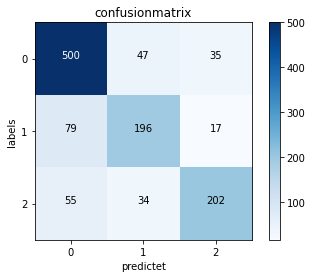

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)
classes = range(0,3)
plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()

###feature map

In [ ]:
imgs_batch= test_generator.next()
imgs_batch[1][0]
len(imgs_batch[0])

64

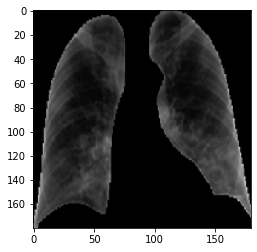

In [ ]:
index = 18
img= imgs_batch[0]
img = img[index]
img_d = img.reshape(imsize, imsize,3)
img = img_d[tf.newaxis, ...]
plt.imshow(img_d, cmap='gray')
plt.show()

In [ ]:
ixs = [0, 2, 5]
outputs = [model.layers[i].output for i in ixs]
feat_model = Model(inputs=model.inputs, outputs=outputs)
feat_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7_input (InputLayer)  [(None, 180, 180, 3)]    0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 41, 41, 64)        3692

In [ ]:
feature_maps = feat_model.predict(img)

1/1 [==============================] - 0s 163ms/step


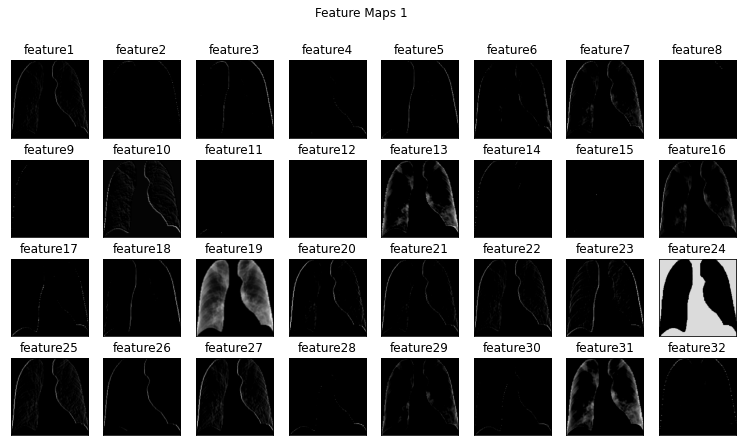

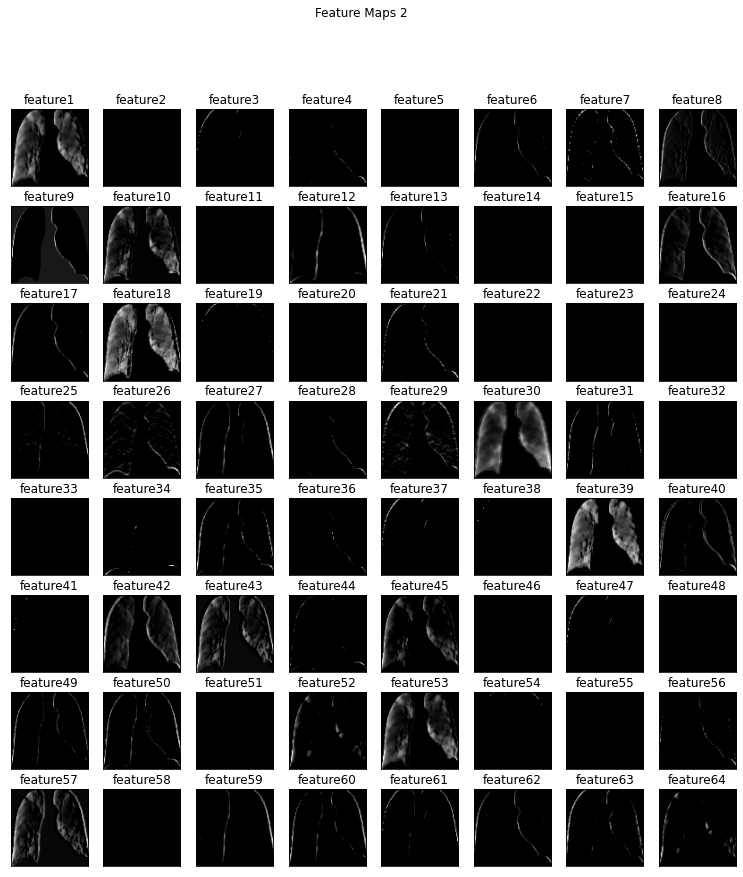

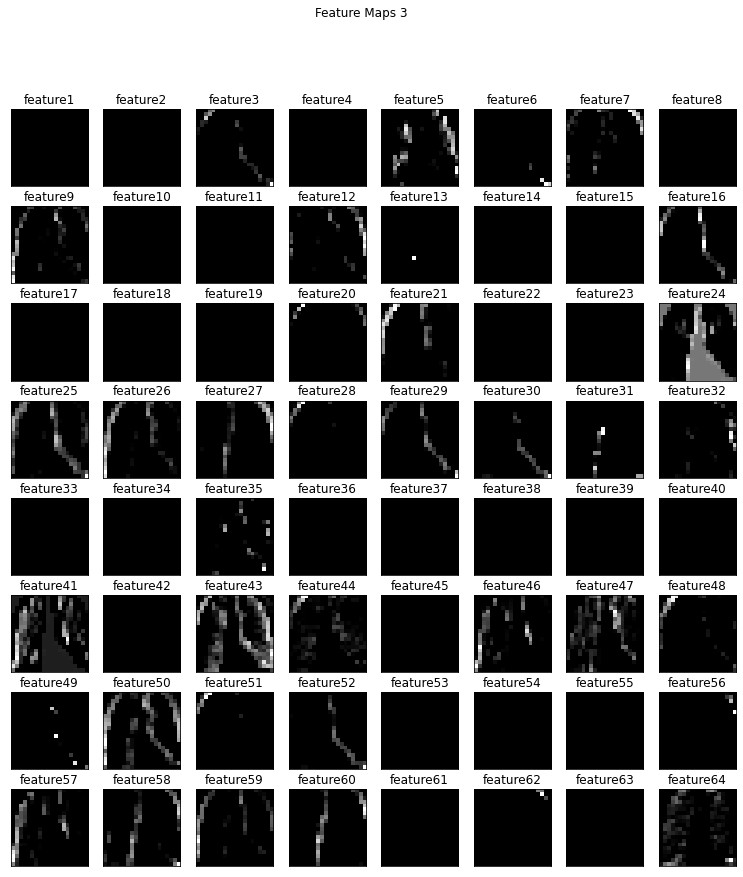

In [ ]:
count=1
for fmap in feature_maps:
    # plot all maps in an x8 squares
    ix = 1
    square = int((fmap.shape[-1])/8)
    square2 = 8
    if square <= 4:
        figsize = (13, 7)
    elif square <= 8:
        figsize = (13,14)
    elif square <= 16:
        figsize = (13, 28)   
    elif square <= 32:
        figsize = (13, 56)     
    plt.figure(figsize=figsize)
    plt.suptitle("Feature Maps " + str(count))
    for _ in range(square2):
        for _ in range(square):
            if (ix-1) < fmap.shape[-1]:
                ax = plt.subplot(square, square2, ix)
                ax.set_title("feature" + str(ix))
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1
            else:
                break
    count += 1 
    plt.show()

###heatmap batch

1/1 [==============================] - 0s 67ms/step


IndexError: ignored

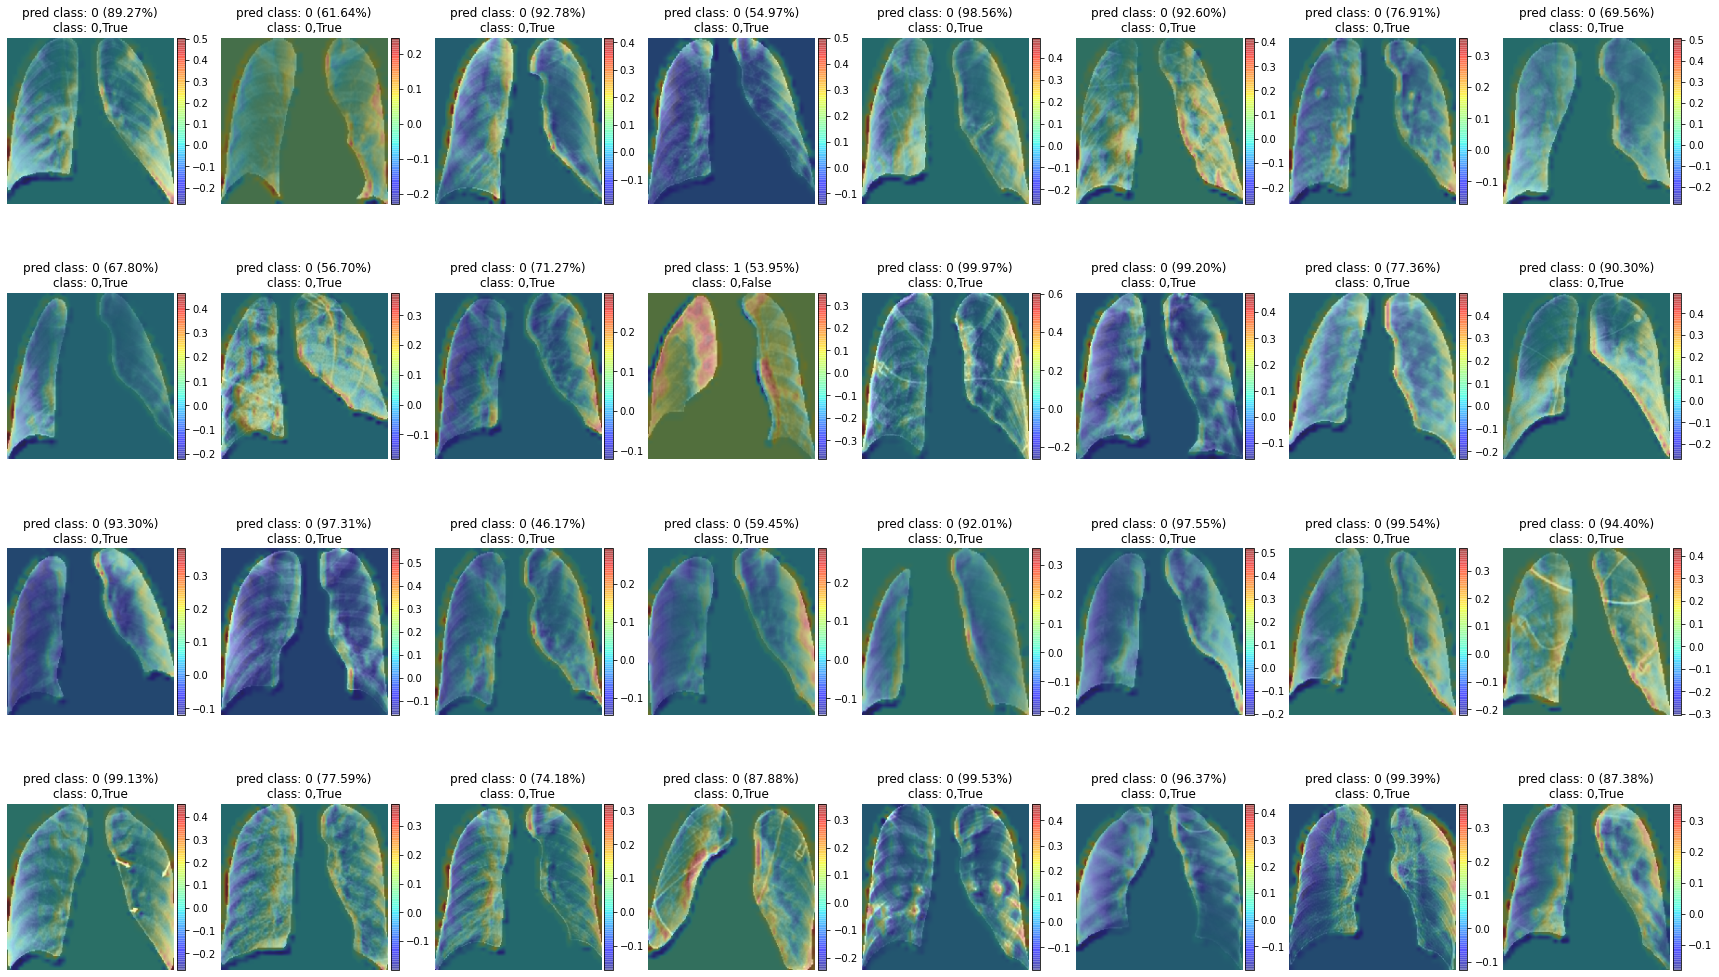

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
index = 31
img_class= imgs_batch[1]
img= imgs_batch[0]
img_t = img[index]
img_class_t = img_class[index]
img_t = img_t[tf.newaxis, ...]

batch=img
batch_class=img_class

last_conv_layer = model.get_layer('max_pooling2d_8')

model_fm = tf.keras.Model(inputs=model.inputs, outputs=[model.output,last_conv_layer.output])
num_rows = 4
num_cols = 8
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 18))

for c,(i,j) in enumerate(zip(batch, batch_class)):
  
  median_value = round(np.mean(i),0)
  i1 = i[tf.newaxis, ...]
  model_out, feature_maps = model_fm.predict(i1)
  feature_maps = np.squeeze(feature_maps)
  model_out = np.squeeze(model_out)
  weights = model.layers[-1].weights[0]
  max_idx = np.argmax( model_out )
  winning_weights = weights[:, max_idx]
  CAM = np.zeros(feature_maps.shape[:2])

  im_h, im_w = i.shape[:2]

  for k, wk in enumerate(winning_weights):
    # get feature map k
    feature_map_k = feature_maps[..., k]
    # get activation of map k (multiply Fk with wk)
    activation_k = feature_map_k * wk
    CAM += activation_k

  CAM=CAM.numpy()
  i1=i1.reshape(imsize,imsize)
  CAM.shape
  # resize CAM
  heatmap = cv2.resize(CAM, (i.shape[1], i.shape[0]))
  row = c // num_cols
  col = c % num_cols

  # Create an axes divider for the subplot
  divider = make_axes_locatable(axs[row, col])

  # Create the colorbar axis on the right of the subplot
  cax = divider.append_axes("right", size="5%", pad=0.05)

  axs[row, col].imshow(i1, alpha=1, cmap='gray')
  im=axs[row, col].imshow(heatmap, cmap='jet', alpha=0.3)
  title = f"pred class: {max_idx} ({model_out[max_idx]*100:.2f}%)\nclass: {np.argmax(j)},{max_idx==np.argmax(j)}"
  axs[row, col].set_title(title)
  axs[row, col].axis('off')
  fig.colorbar(im,cax=cax)
 


plt.show()

###augmentation2

In [ ]:
seed=42
dir_imgs_train = '/content/data_cropped_lungs/Lung Segmentation Data/Train'
dir_imgs_val = '/content/data_cropped_lungs/Lung Segmentation Data/Val'
dir_imgs_test = '/content/data_cropped_lungs/Lung Segmentation Data/Test'
c_mode = "grayscale"
imsize = 180
batch_size=64

def custom_augmentation(np_tensor):
  np_tensor=np_tensor/255
  def random_contrast(np_tensor):
    return tf.clip_by_value(tf.image.random_contrast(np_tensor, 0.9,1),0,1)
    
  def random_brightness(np_tensor):        
    return tf.clip_by_value(tf.image.random_brightness(np_tensor,(0.2)),0,1)
 
  def random_gamma(np_tensor):
    gamma = tf.random.uniform([1], 0.9, 1)
    return tf.clip_by_value(tf.image.adjust_gamma(np_tensor, gamma),0,1)  

  def gaussian(np_tensor):
    np_tensor = tf.clip_by_value(gaussian_filter(np_tensor, sigma=0.6),0,1)
    return np_tensor

  np_tensor = random_gamma(np_tensor)
  np_tensor = random_brightness(np_tensor)     
  np_tensor = random_contrast(np_tensor)  
  np_tensor =gaussian(np_tensor)
  return np_tensor

train_data_generator = ImageDataGenerator(fill_mode='constant', cval=0,
                                         #rescale=1./255, 
                                         preprocessing_function = custom_augmentation,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         zoom_range=0.1,
                                         rotation_range=20)

train2_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize), 
                                                           #color_mode=c_mode,
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

val2_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = True,
                                                           seed = seed)

test2_generator = ImageDataGenerator(rescale=1./255,fill_mode='constant', cval=0,).flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode="categorical",
                                                           target_size=(imsize,imsize),
                                                           #color_mode=c_mode, 
                                                           batch_size=batch_size,
                                                           shuffle = False,
                                                           seed = seed)

Found 21711 images belonging to 3 classes.
Found 4375 images belonging to 3 classes.
Found 6787 images belonging to 3 classes.


IndexError: ignored

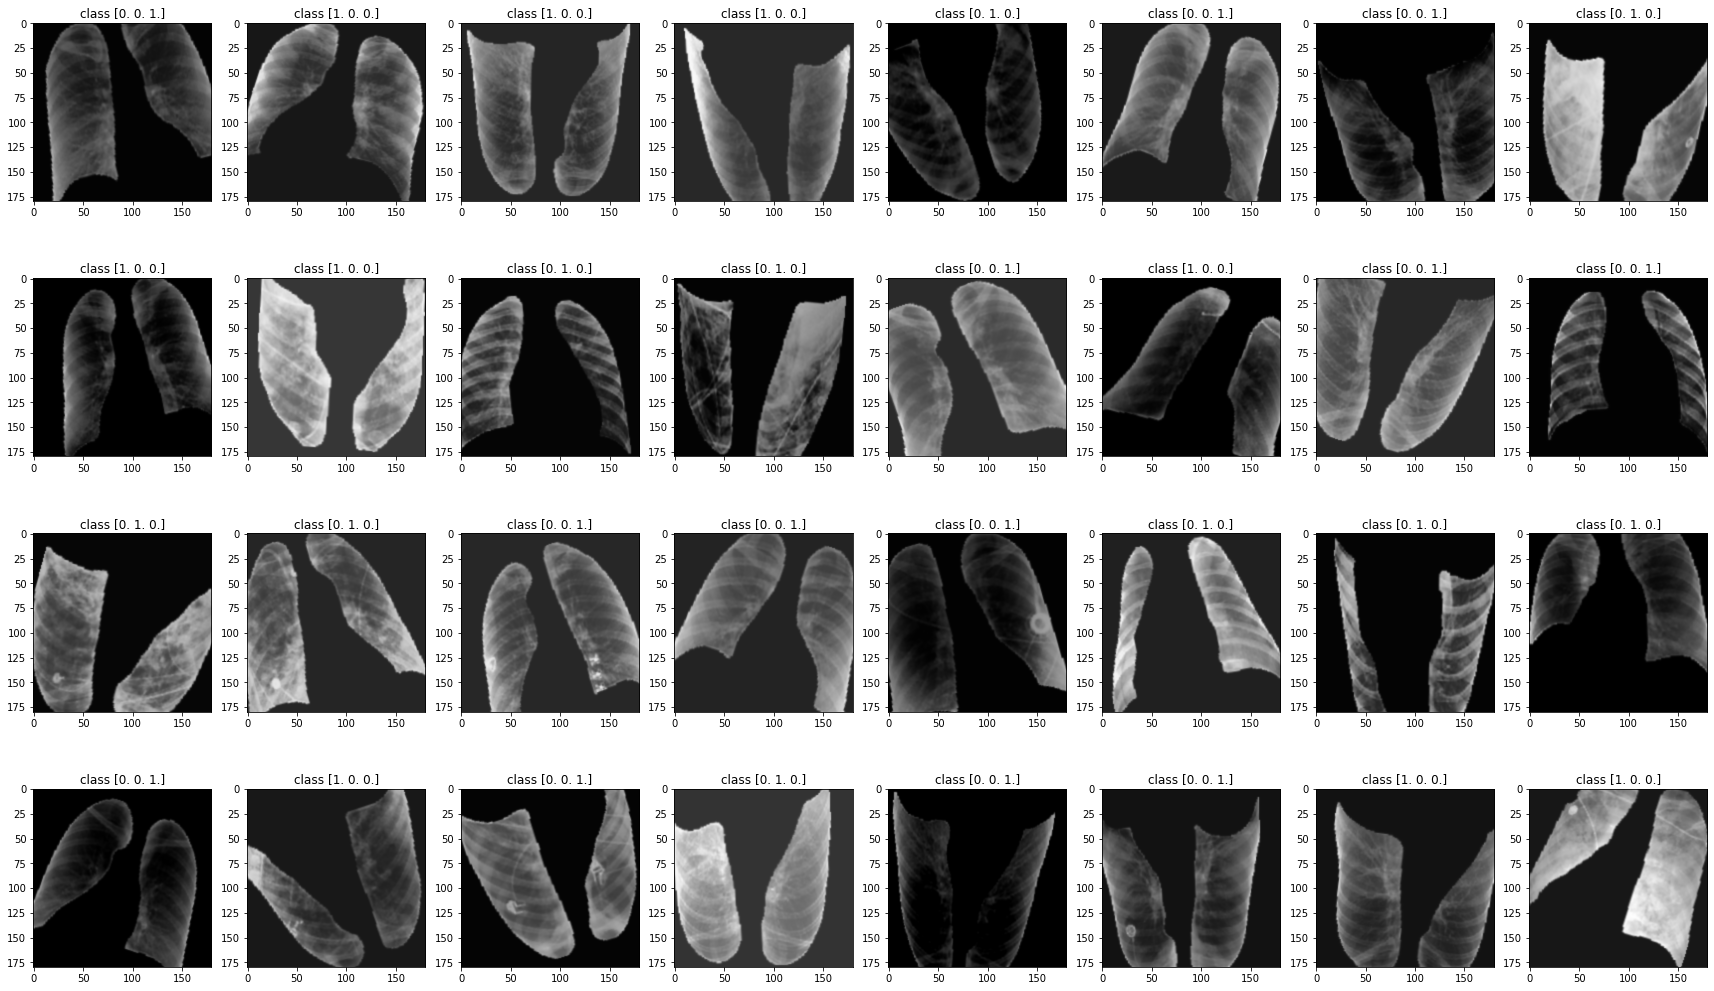

In [ ]:
#Image Data Generator testing/tuning
imgs_batch= train_generator.next()
num_rows = 4
num_cols = 8
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 18))
for i, (img,img_class) in enumerate(zip(imgs_batch[0],imgs_batch[1])):
    row = i // num_cols
    col = i % num_cols
    #img = img.reshape((imsize,imsize))
    axs[row, col].imshow(img, cmap='gray')
    axs[row,col].set_title("class " + str(np.argmax(img_class)));
plt.show()

###train2

In [ ]:
initial_learning_rate = 0.002
steps= 4
decay=0.6
min_delta=0
patience=8
monitor="val_loss"
epochs=60

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)                                                            
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta=min_delta,
    patience=patience,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)
class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
training_history = model.fit(train2_generator, validation_data = val2_generator,epochs = epochs,callbacks=[lr_callback, es_callback, stopper]) 

Epoch 1/60
679/679 [==============================] - 78s 111ms/step - loss: 0.7984 - accuracy: 0.6474 - val_loss: 0.7163 - val_accuracy: 0.7017 - lr: 0.0020
Epoch 2/60
679/679 [==============================] - 36s 52ms/step - loss: 0.7416 - accuracy: 0.6773 - val_loss: 0.6705 - val_accuracy: 0.7408 - lr: 0.0020
Epoch 3/60
679/679 [==============================] - 35s 52ms/step - loss: 0.7202 - accuracy: 0.6885 - val_loss: 0.7923 - val_accuracy: 0.6505 - lr: 0.0020
Epoch 4/60
679/679 [==============================] - 35s 52ms/step - loss: 0.6993 - accuracy: 0.6965 - val_loss: 0.6316 - val_accuracy: 0.7520 - lr: 0.0020
Epoch 5/60
679/679 [==============================] - 38s 56ms/step - loss: 0.6652 - accuracy: 0.7148 - val_loss: 0.6480 - val_accuracy: 0.7378 - lr: 0.0012
Epoch 6/60
679/679 [==============================] - 35s 52ms/step - loss: 0.6478 - accuracy: 0.7199 - val_loss: 0.6487 - val_accuracy: 0.7426 - lr: 0.0012
Epoch 7/60
679/679 [==============================] - 37s

###evaluation

In [ ]:
test_pred = model.predict(test2_generator)
# Evaluation 
score = model.evaluate(test2_generator)
score

107/107 [==============================] - 100s 928ms/step - loss: 0.7240 - accuracy: 0.6909


[0.7240405678749084, 0.6908796429634094]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = test2_generator.classes

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      2394
           1       0.77      0.64      0.70      2253
           2       0.71      0.71      0.71      2140

    accuracy                           0.69      6787
   macro avg       0.70      0.69      0.69      6787
weighted avg       0.70      0.69      0.69      6787



[[1731  231  432]
 [ 609 1445  199]
 [ 417  210 1513]]


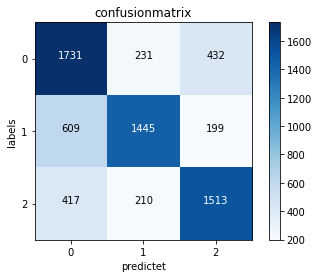

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)
classes = range(0,3)
plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()

###feature map

In [ ]:
imgs_batch= test2_generator.next()
imgs_batch[1][0]
len(imgs_batch[0])

64

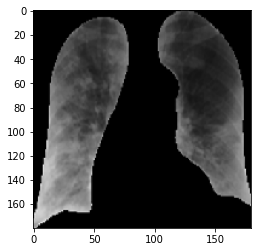

In [ ]:
index = 18
img= imgs_batch[0]
img = img[index]
img_d = img.reshape(imsize, imsize,3)
img = img_d[tf.newaxis, ...]
plt.imshow(img_d, cmap='gray')
plt.show()

In [ ]:
ixs = [0, 2, 5]
outputs = [model.layers[i].output for i in ixs]
feat_model = Model(inputs=model.inputs, outputs=outputs)
feat_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7_input (InputLayer)  [(None, 180, 180, 3)]    0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 41, 41, 64)        3692

In [ ]:
feature_maps = feat_model.predict(img)

1/1 [==============================] - 0s 165ms/step


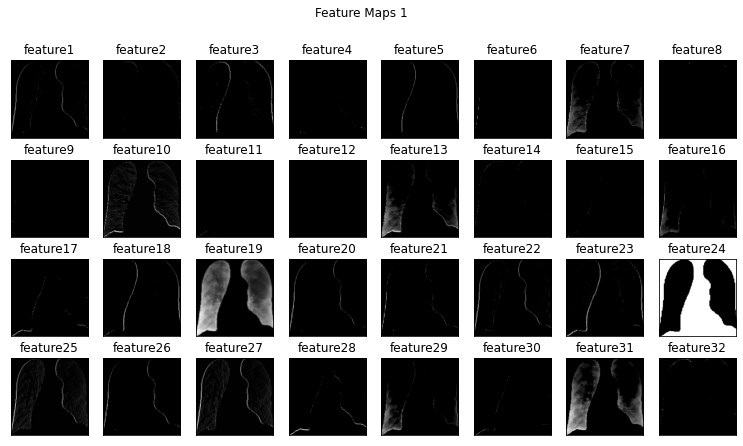

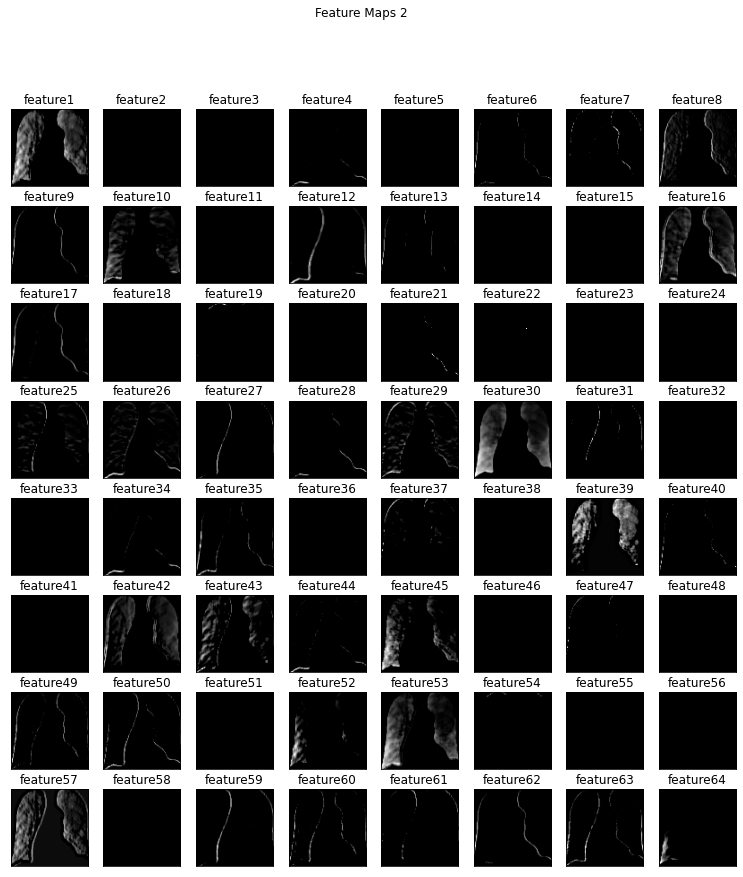

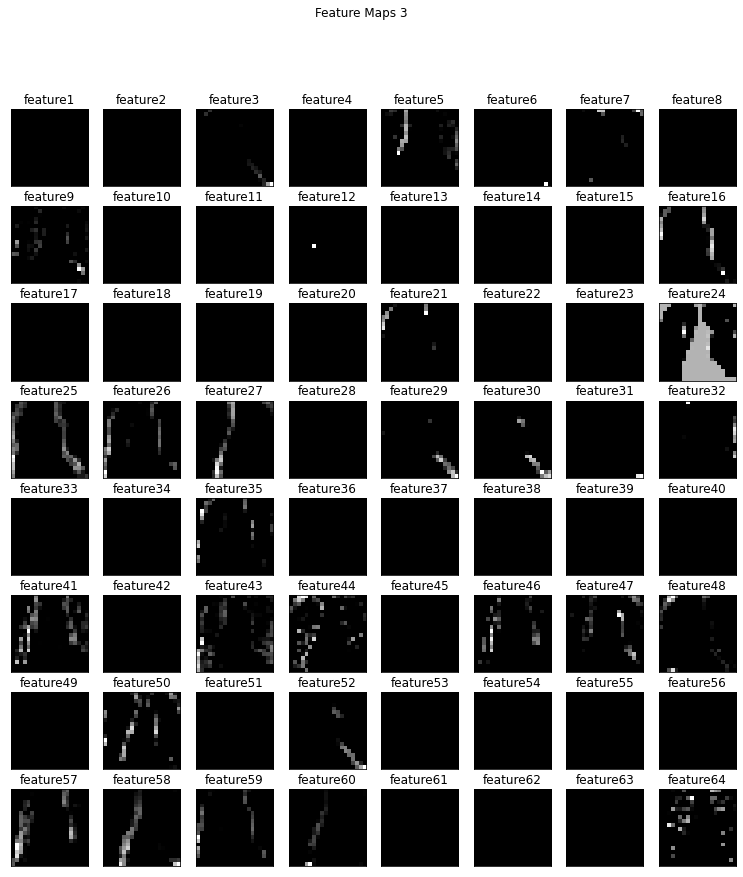

In [ ]:
count=1
for fmap in feature_maps:
    # plot all maps in an x8 squares
    ix = 1
    square = int((fmap.shape[-1])/8)
    square2 = 8
    if square <= 4:
        figsize = (13, 7)
    elif square <= 8:
        figsize = (13,14)
    elif square <= 16:
        figsize = (13, 28)   
    elif square <= 32:
        figsize = (13, 56)     
    plt.figure(figsize=figsize)
    plt.suptitle("Feature Maps " + str(count))
    for _ in range(square2):
        for _ in range(square):
            if (ix-1) < fmap.shape[-1]:
                ax = plt.subplot(square, square2, ix)
                ax.set_title("feature" + str(ix))
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
                ix += 1
            else:
                break
    count += 1 
    plt.show()

###heatmap batch

1/1 [==============================] - 0s 63ms/step


IndexError: ignored

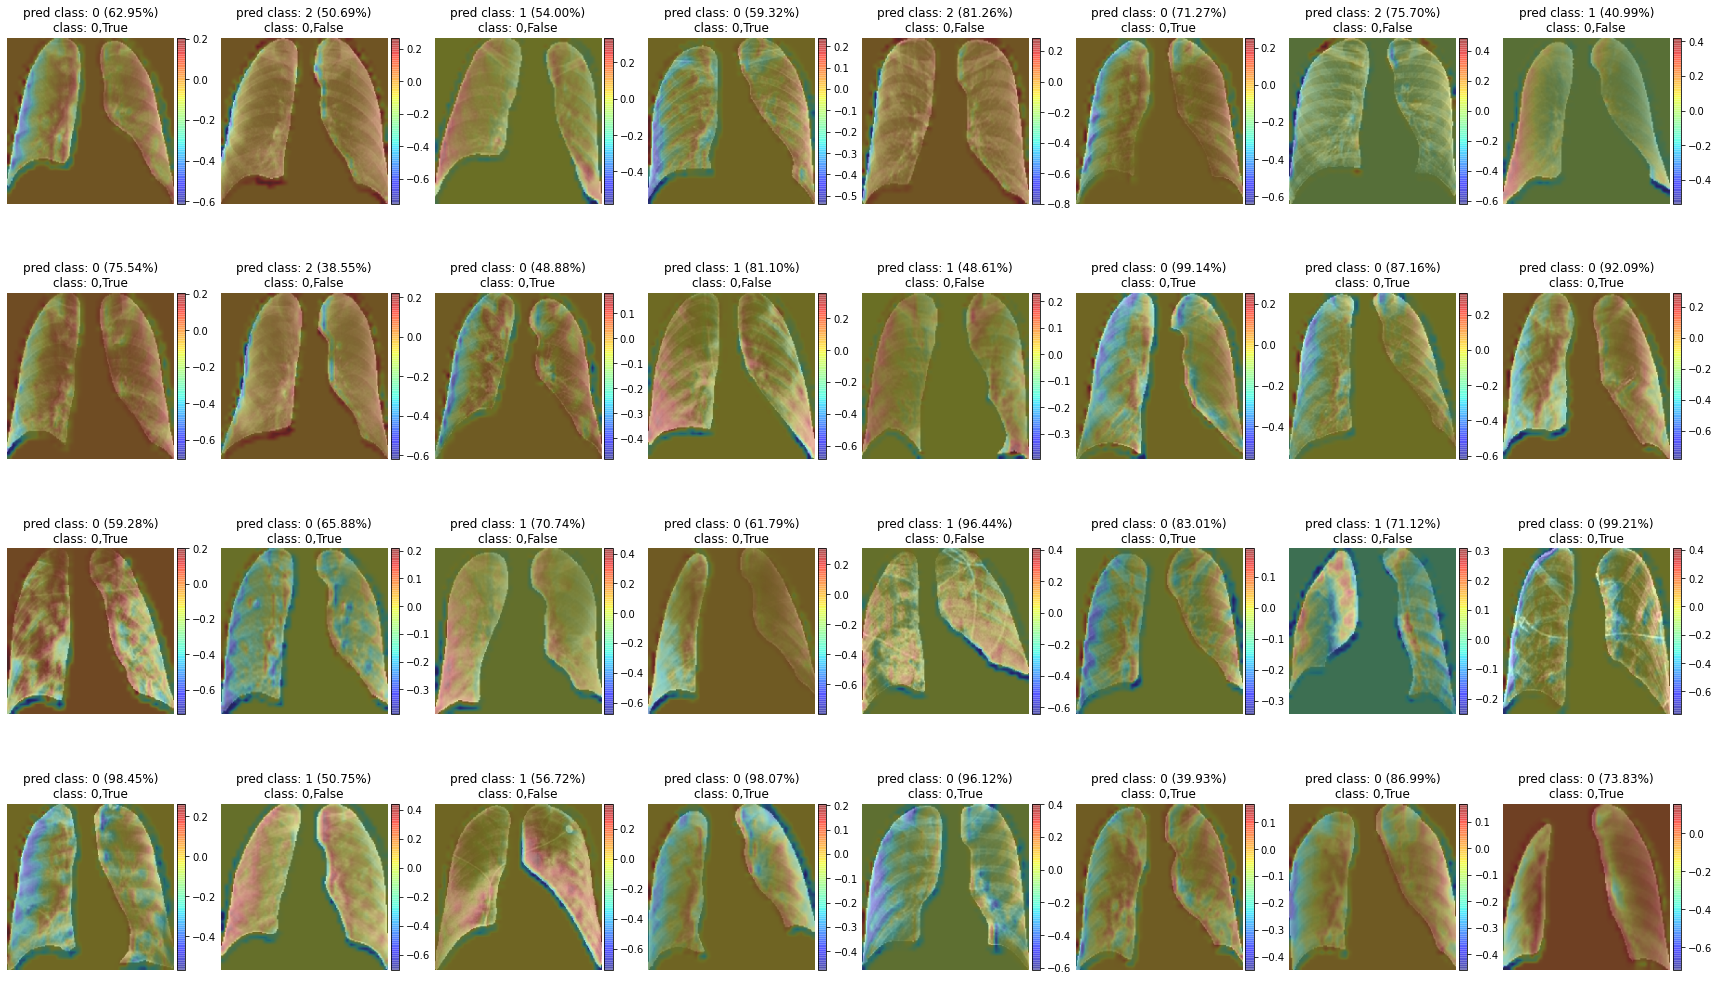

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
index = 31
img_class= imgs_batch[1]
img= imgs_batch[0]
img_t = img[index]
img_class_t = img_class[index]
img_t = img_t[tf.newaxis, ...]

batch=img
batch_class=img_class

last_conv_layer = model.get_layer('max_pooling2d_8')

model_fm = tf.keras.Model(inputs=model.inputs, outputs=[model.output,last_conv_layer.output])
num_rows = 4
num_cols = 8
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 18))

for c,(i,j) in enumerate(zip(batch, batch_class)):
  
  median_value = round(np.mean(i),0)
  i1 = i[tf.newaxis, ...]
  model_out, feature_maps = model_fm.predict(i1)
  feature_maps = np.squeeze(feature_maps)
  model_out = np.squeeze(model_out)
  weights = model.layers[-1].weights[0]
  max_idx = np.argmax( model_out )
  winning_weights = weights[:, max_idx]
  CAM = np.zeros(feature_maps.shape[:2])

  im_h, im_w = i.shape[:2]

  for k, wk in enumerate(winning_weights):
    # get feature map k
    feature_map_k = feature_maps[..., k]
    # get activation of map k (multiply Fk with wk)
    activation_k = feature_map_k * wk
    CAM += activation_k

  CAM=CAM.numpy()
  i1=i1.reshape(imsize,imsize)
  CAM.shape
  # resize CAM
  heatmap = cv2.resize(CAM, (i.shape[1], i.shape[0]))
  row = c // num_cols
  col = c % num_cols

  # Create an axes divider for the subplot
  divider = make_axes_locatable(axs[row, col])

  # Create the colorbar axis on the right of the subplot
  cax = divider.append_axes("right", size="5%", pad=0.05)

  axs[row, col].imshow(i1, alpha=1, cmap='gray')
  im=axs[row, col].imshow(heatmap, cmap='jet', alpha=0.3)
  title = f"pred class: {max_idx} ({model_out[max_idx]*100:.2f}%)\nclass: {np.argmax(j)},{max_idx==np.argmax(j)}"
  axs[row, col].set_title(title)
  axs[row, col].axis('off')
  fig.colorbar(im,cax=cax)
 


plt.show()